## Introduction

This notebook provides a comprehensive pipeline for extracting, summarizing, and analyzing risk factors and financial performance trends from company meeting transcripts (including both management discussion and Q&A sessions). Using advanced language models such as Mistral-7B and hybrid summarization approaches, the notebook:

Summarizes meeting and Q&A transcripts to generate concise, structured overviews.

Extracts key risk factors and quantifies their mentions over time.

Performs trend analysis on risks and financial metrics by quarter.

Compares the performance of different summarization models using automated metrics (e.g., ROUGE).

Visualizes results to reveal temporal trends and patterns.

This workflow is intended for researchers, analysts, and practitioners interested in leveraging natural language processing (NLP) to automate the analysis of large collections of financial or corporate meeting documents.

## SECTION 1/2: Setup & Imports / Load Data

In [20]:
# import libs

import os
import sys
import logging

In [21]:
# setup consts

IS_COLAB = 'google.colab' in sys.modules
OUTPUT_PROCESSED_FILES = True # TODO: Use this if you want to output save files (optional - see below)

REPO_URL = "https://github.com/EErlando/Quarterly-Bytes.git"
REPO_NAME = "src"
REPO_BRANCH = "main" # TODO: UPDATE THIS TO YOU BRANCH - DEFAULT TO MAIN
ALL_TRANSCRIPTS_PATH = "data/raw/JP Morgan/Transcripts"
NOTEBOOK_DIR = "notebooks" # TODO: UPDATE THIS TO YOUR NOTEBOOK DIRECTORY (e.g. 1_data_extraction_and_processing)

In [22]:
# get github tokens

if IS_COLAB:
    from google.colab import userdata
    GITHUB_USERNAME = userdata.get('github_user')
    GITHUB_TOKEN = userdata.get('github_token')
    GITHUB_EMAIL = userdata.get('github_email')

In [ ]:
# Clone and Pull Latest from Repository - Colab Specific

if IS_COLAB:
    !git config pull.rebase false
    if os.path.exists(REPO_NAME):
        print(f"Directory '{REPO_NAME}' already exists. Pulling latest changes...")
        %cd {REPO_NAME}
        !git pull origin {REPO_BRANCH} --quiet
        %cd ..
    else:
        print(f"Cloning repository into '{REPO_NAME}'...")
        !git clone --quiet --branch {REPO_BRANCH} {REPO_URL} {REPO_NAME}
        print("Clone complete.")

    sys.path.append('/content/src/')
    %cd /content/src/
    !pip install -r requirements.txt
else:
    !pip install -r requirements.txt
    if os.path.basename(os.getcwd()) == NOTEBOOK_DIR:
        os.chdir('../') # TODO: UPDATE THIS TO ROOT OF REPO

logging.basicConfig(level=logging.ERROR, format='%(levelname)s: %(message)s')

fatal: not in a git directory
Directory 'src' already exists. Pulling latest changes...
/content/src
/content
/content/src


In [ ]:
# Uncomment below if running in a fresh Colab or Jupyter environment
!pip install summa sumy transformers rouge-score matplotlib torch --quiet
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 127.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install rake_nltk --quiet

In [ ]:
import pandas as pd
import nltk
from summa.summarizer import summarize as summa_summarize
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from transformers import pipeline
import matplotlib.pyplot as plt
import string
import torch

from rake_nltk import Rake
import spacy

nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# load the processed Q&A transcripts

GOLDMAN_SACHS_QNA_PATH = 'data/processed/Goldman Sachs/qna_df.csv'
GOLDMAN_SACHS_MD_PATH = 'data/processed/Goldman Sachs/discussion_df.csv'
JP_MORGAN_QNA_PATH = 'data/processed/JP Morgan/qna_df.csv'
JP_MORGAN_MD_PATH = 'data/processed/JP Morgan/discussion_df.csv'

# df_qna = pd.read_csv(GOLDMAN_SACHS_QNA_PATH) # - UNCOMMENT FOR GOLDMAN SACHS
# df_md = pd.read_csv(GOLDMAN_SACHS_MD_PATH) # - UNCOMMENT FOR GOLDMAN SACHS
qna_df = pd.read_csv(JP_MORGAN_QNA_PATH)
discussion_df = pd.read_csv(JP_MORGAN_MD_PATH)

In [ ]:
## IF USING A NEW NOTEBOOK UNCOMMENT AND LOAD DATA DIRECTLY

# discussion_df = pd.read_csv('discussion_df.csv')
# qna_df = pd.read_csv('qna_df.csv')

## SECTION 3: Helper Functions

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = ''.join(c for c in text if c not in string.punctuation)
    return text

def get_meeting_blocks(df, text_col="content"):
    grouped = df.groupby(["year", "quarter"])[text_col].apply(lambda x: "\n".join(x)).reset_index()
    grouped["block_id"] = grouped["year"].astype(str) + "_Q" + grouped["quarter"].astype(str)
    return grouped

def get_speaker_blocks(df, text_col="content"):
    grouped = df.groupby(["year", "quarter", "speaker"])[text_col].apply(lambda x: "\n".join(x)).reset_index()
    grouped["block_id"] = grouped["year"].astype(str) + "_Q" + grouped["quarter"].astype(str)
    return grouped

def extractive_summary_summa(text, ratio=0.2):
    try:
        return summa_summarize(text, ratio=ratio)
    except Exception:
        return text

def extractive_summary_lexrank(text, sentences_count=3):
    try:
        parser = PlaintextParser.from_string(text, Tokenizer("english"))
        summarizer = LexRankSummarizer()
        summary = summarizer(parser.document, sentences_count)
        return " ".join(str(sentence) for sentence in summary)
    except Exception:
        return text

def abstractive_summary(text, model_pipe, max_length=400, min_length=150, model_name="bart"):
    if model_name == "bart":
        limit = 512 # ~512 tokens for BART-large-cnn
    elif model_name == "pegasus":
        limit = 1024
    else:
        limit = 512

    if text is None:
        return ""
    # Truncate to limit
    if len(str(text).split()) > limit:
        text = " ".join(str(text).split()[:limit])
    try:
        out = model_pipe(text, max_length=max_length, min_length=min_length, do_sample=False)
        return out[0]['summary_text']
    except Exception as e:
        return f"[Summary failed: {e}]"

def extract_keywords(text, top_n=10):
    r = Rake()
    r.extract_keywords_from_text(str(text))
    keywords = r.get_ranked_phrases()
    return keywords[:top_n]

def extract_entities(text):
    if text is None or str(text).strip() == "":
        return set()
    doc = nlp(str(text))
    return set([ent.text for ent in doc.ents])

def display_safe(val):
    if val is None or str(val).strip() == "" or str(val).lower() == "nan":
        return "Summary not available."
    return val

def word_overlap(text1, text2):
    set1 = set(str(text1).lower().split())
    set2 = set(str(text2).lower().split())
    if not set1 or not set2:
        return 0.0
    return len(set1 & set2) / len(set1 | set2)


## SECTION 4: Initialize Summarization Models

In [ ]:
# General BART

DEVICE = -1

general_bart_pipe = pipeline(
    "summarization",
    model="facebook/bart-large-cnn",
    device=DEVICE
)

# PEGASUS
pegasus_pipe = pipeline(
    "summarization",
    model="google/pegasus-xsum",
    device=DEVICE,
    truncation=True
)


Device set to use cpu
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


## SECTION 5: Meeting-Level Summarization (Discussion & Q&A)

In [ ]:
# --- Discussion meetings ---
discussion_meetings = get_meeting_blocks(discussion_df)
discussion_meeting_results = []

for _, row in discussion_meetings.iterrows():
    text = row["content"]
    block_id = row["block_id"]

    if text and len(str(text).split()) > 5:
        ext_summa = extractive_summary_summa(text)
        ext_lexrank = extractive_summary_lexrank(text)
        abstractive_bart = abstractive_summary(text, general_bart_pipe, model_name="bart")
        abstractive_pegasus = abstractive_summary(text, pegasus_pipe, model_name="pegasus")
    else:
        # For short/empty text, just return original
        ext_summa = text
        ext_lexrank = text
        abstractive_bart = text
        abstractive_pegasus = text

    discussion_meeting_results.append({
        "meeting": block_id,
        "original_text": text,
        "extractive_summa": ext_summa,
        "extractive_lexrank": ext_lexrank,
        "abstractive_bart": abstractive_bart,
        "abstractive_pegasus": abstractive_pegasus,
        "original_len": len(str(text).split()) if text else 0,
        "extractive_summa_len": len(ext_summa.split()) if ext_summa else 0,
        "extractive_lexrank_len": len(ext_lexrank.split()) if ext_lexrank else 0,
        "abstractive_bart_len": len(abstractive_bart.split()) if abstractive_bart else 0,
        "abstractive_pegasus_len": len(abstractive_pegasus.split()) if abstractive_pegasus else 0
    })
discussion_meeting_summaries = pd.DataFrame(discussion_meeting_results)

# --- Q&A meetings ---
qna_meetings = get_meeting_blocks(qna_df)
qna_meeting_results = []

for _, row in qna_meetings.iterrows():
    text = row["content"]
    block_id = row["block_id"]

    if text and len(str(text).split()) > 5:
        ext_summa = extractive_summary_summa(text)
        ext_lexrank = extractive_summary_lexrank(text)
        abstractive_bart = abstractive_summary(text, general_bart_pipe, model_name="bart")
        abstractive_pegasus = abstractive_summary(text, pegasus_pipe, model_name="pegasus")
    else:
        ext_summa = text
        ext_lexrank = text
        abstractive_bart = text
        abstractive_pegasus = text

    qna_meeting_results.append({
        "meeting": block_id,
        "original_text": text,
        "extractive_summa": ext_summa,
        "extractive_lexrank": ext_lexrank,
        "abstractive_bart": abstractive_bart,
        "abstractive_pegasus": abstractive_pegasus,
        "original_len": len(str(text).split()) if text else 0,
        "extractive_summa_len": len(ext_summa.split()) if ext_summa else 0,
        "extractive_lexrank_len": len(ext_lexrank.split()) if ext_lexrank else 0,
        "abstractive_bart_len": len(abstractive_bart.split()) if abstractive_bart else 0,
        "abstractive_pegasus_len": len(abstractive_pegasus.split()) if abstractive_pegasus else 0
    })
qna_meeting_summaries = pd.DataFrame(qna_meeting_results)


## SECTION 6: Speaker-Level Summarization (Discussion & Q&A)

In [ ]:
# --- Discussion speakers ---
discussion_speakers = get_speaker_blocks(discussion_df)
discussion_speaker_results = []

for _, row in discussion_meetings.iterrows():
    text = row["content"]
    block_id = row["block_id"]

    if text and len(str(text).split()) > 5:
        ext_summa = extractive_summary_summa(text)
        ext_lexrank = extractive_summary_lexrank(text)
        abstractive_bart = abstractive_summary(text, general_bart_pipe, model_name="bart")
        abstractive_pegasus = abstractive_summary(text, pegasus_pipe, model_name="pegasus")
    else:
        # For short/empty text, just return original
        ext_summa = text
        ext_lexrank = text
        abstractive_bart = text
        abstractive_pegasus = text

    discussion_meeting_results.append({
        "meeting": block_id,
        "original_text": text,
        "extractive_summa": ext_summa,
        "extractive_lexrank": ext_lexrank,
        "abstractive_bart": abstractive_bart,
        "abstractive_pegasus": abstractive_pegasus,
        "original_len": len(str(text).split()) if text else 0,
        "extractive_summa_len": len(ext_summa.split()) if ext_summa else 0,
        "extractive_lexrank_len": len(ext_lexrank.split()) if ext_lexrank else 0,
        "abstractive_bart_len": len(abstractive_bart.split()) if abstractive_bart else 0,
        "abstractive_pegasus_len": len(abstractive_pegasus.split()) if abstractive_pegasus else 0
    })
discussion_speaker_summaries = pd.DataFrame(discussion_speaker_results)

# --- Q&A speakers ---
qna_speakers = get_speaker_blocks(qna_df)
qna_speaker_results = []

for _, row in qna_meetings.iterrows():
    text = row["content"]
    block_id = row["block_id"]

    if text and len(str(text).split()) > 5:
        ext_summa = extractive_summary_summa(text)
        ext_lexrank = extractive_summary_lexrank(text)
        abstractive_bart = abstractive_summary(text, general_bart_pipe, model_name="bart")
        abstractive_pegasus = abstractive_summary(text, pegasus_pipe, model_name="pegasus")
    else:
        ext_summa = text
        ext_lexrank = text
        abstractive_bart = text
        abstractive_pegasus = text

    qna_meeting_results.append({
        "meeting": block_id,
        "original_text": text,
        "extractive_summa": ext_summa,
        "extractive_lexrank": ext_lexrank,
        "abstractive_bart": abstractive_bart,
        "abstractive_pegasus": abstractive_pegasus,
        "original_len": len(str(text).split()) if text else 0,
        "extractive_summa_len": len(ext_summa.split()) if ext_summa else 0,
        "extractive_lexrank_len": len(ext_lexrank.split()) if ext_lexrank else 0,
        "abstractive_bart_len": len(abstractive_bart.split()) if abstractive_bart else 0,
        "abstractive_pegasus_len": len(abstractive_pegasus.split()) if abstractive_pegasus else 0
    })
qna_speaker_summaries = pd.DataFrame(qna_speaker_results)


## SECTION 7: Summary Comparison, Overlap, Coverage, and Keywords

In [ ]:
import nltk
nltk.download('punkt_tab')


# Calculate word overlap between summaries
for df in [discussion_meeting_summaries, qna_meeting_summaries]:
    df['summa_bart_overlap'] = df.apply(lambda row: word_overlap(row['extractive_summa'], row['abstractive_bart']), axis=1)
    df['summa_pegasus_overlap'] = df.apply(lambda row: word_overlap(row['extractive_summa'], row['abstractive_pegasus']), axis=1)
    df['bart_pegasus_overlap'] = df.apply(lambda row: word_overlap(row['abstractive_bart'], row['abstractive_pegasus']), axis=1)

# Entity coverage (how many entities in summary are in the original)
for df in [discussion_meeting_summaries, qna_meeting_summaries]:
    df['entities_in_original'] = df['original_text'].apply(extract_entities)
    df['entities_in_summa'] = df['extractive_summa'].apply(extract_entities) ### SUMA UPDAT
    df['entities_in_bart'] = df['abstractive_bart'].apply(extract_entities)
    df['entities_in_pegasus'] = df['abstractive_pegasus'].apply(extract_entities)

    df['bart_entity_coverage'] = df.apply(
        lambda row: len(row['entities_in_bart'] & row['entities_in_original']) / (len(row['entities_in_original']) or 1), axis=1)
    df['pegasus_entity_coverage'] = df.apply(
        lambda row: len(row['entities_in_pegasus'] & row['entities_in_original']) / (len(row['entities_in_original']) or 1), axis=1)
    df['summa_entity_coverage'] = df.apply(                                         # <-- ADDED BLOCK
        lambda row: len(row['entities_in_summa'] & row['entities_in_original']) / (len(row['entities_in_original']) or 1), axis=1)

    # Calculate entity overlap
    df['entity_overlap_original_bart'] = df.apply(
        lambda row: len(row['entities_in_bart'] & row['entities_in_original']) / (len(row['entities_in_bart']) | len(row['entities_in_original']) or 1), axis=1)
    df['entity_overlap_bart_pegasus'] = df.apply(
        lambda row: len(row['entities_in_bart'] & row['entities_in_pegasus']) / (len(row['entities_in_bart']) | len(row['entities_in_pegasus']) or 1), axis=1)
    df['entity_overlap_original_summa'] = df.apply(                                 # <-- ADDED BLOCK
        lambda row: len(row['entities_in_summa'] & row['entities_in_original']) / (len(row['entities_in_summa']) or 1), axis=1)


# Extract keywords for each summary and original
for df in [discussion_meeting_summaries, qna_meeting_summaries]:
    df['keywords_original'] = df['original_text'].apply(extract_keywords)
    df['keywords_summa'] = df['extractive_summa'].apply(extract_keywords)
    df['keywords_bart'] = df['abstractive_bart'].apply(extract_keywords)
    df['keywords_pegasus'] = df['abstractive_pegasus'].apply(extract_keywords)

    # Calculate keyword overlap
    df['keyword_overlap_original_bart'] = df.apply(
        lambda row: len(set(row['keywords_original']) & set(row['keywords_bart'])) / (len(set(row['keywords_original'])) | len(set(row['keywords_bart'])) or 1), axis=1)
    df['keyword_overlap_original_pegasus'] = df.apply(
        lambda row: len(set(row['keywords_original']) & set(row['keywords_pegasus'])) / (len(set(row['keywords_original'])) | len(set(row['keywords_pegasus'])) or 1), axis=1) # <-- ADDED BLOCK
    df['keyword_overlap_original_summa'] = df.apply(
        lambda row: len(set(row['keywords_original']) & set(row['keywords_summa'])) / (len(set(row['keywords_original'])) | len(set(row['keywords_summa'])) or 1), axis=1) # <-- ADDED BLOCK


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## SECTION 8: Plots of Overlap and Coverage

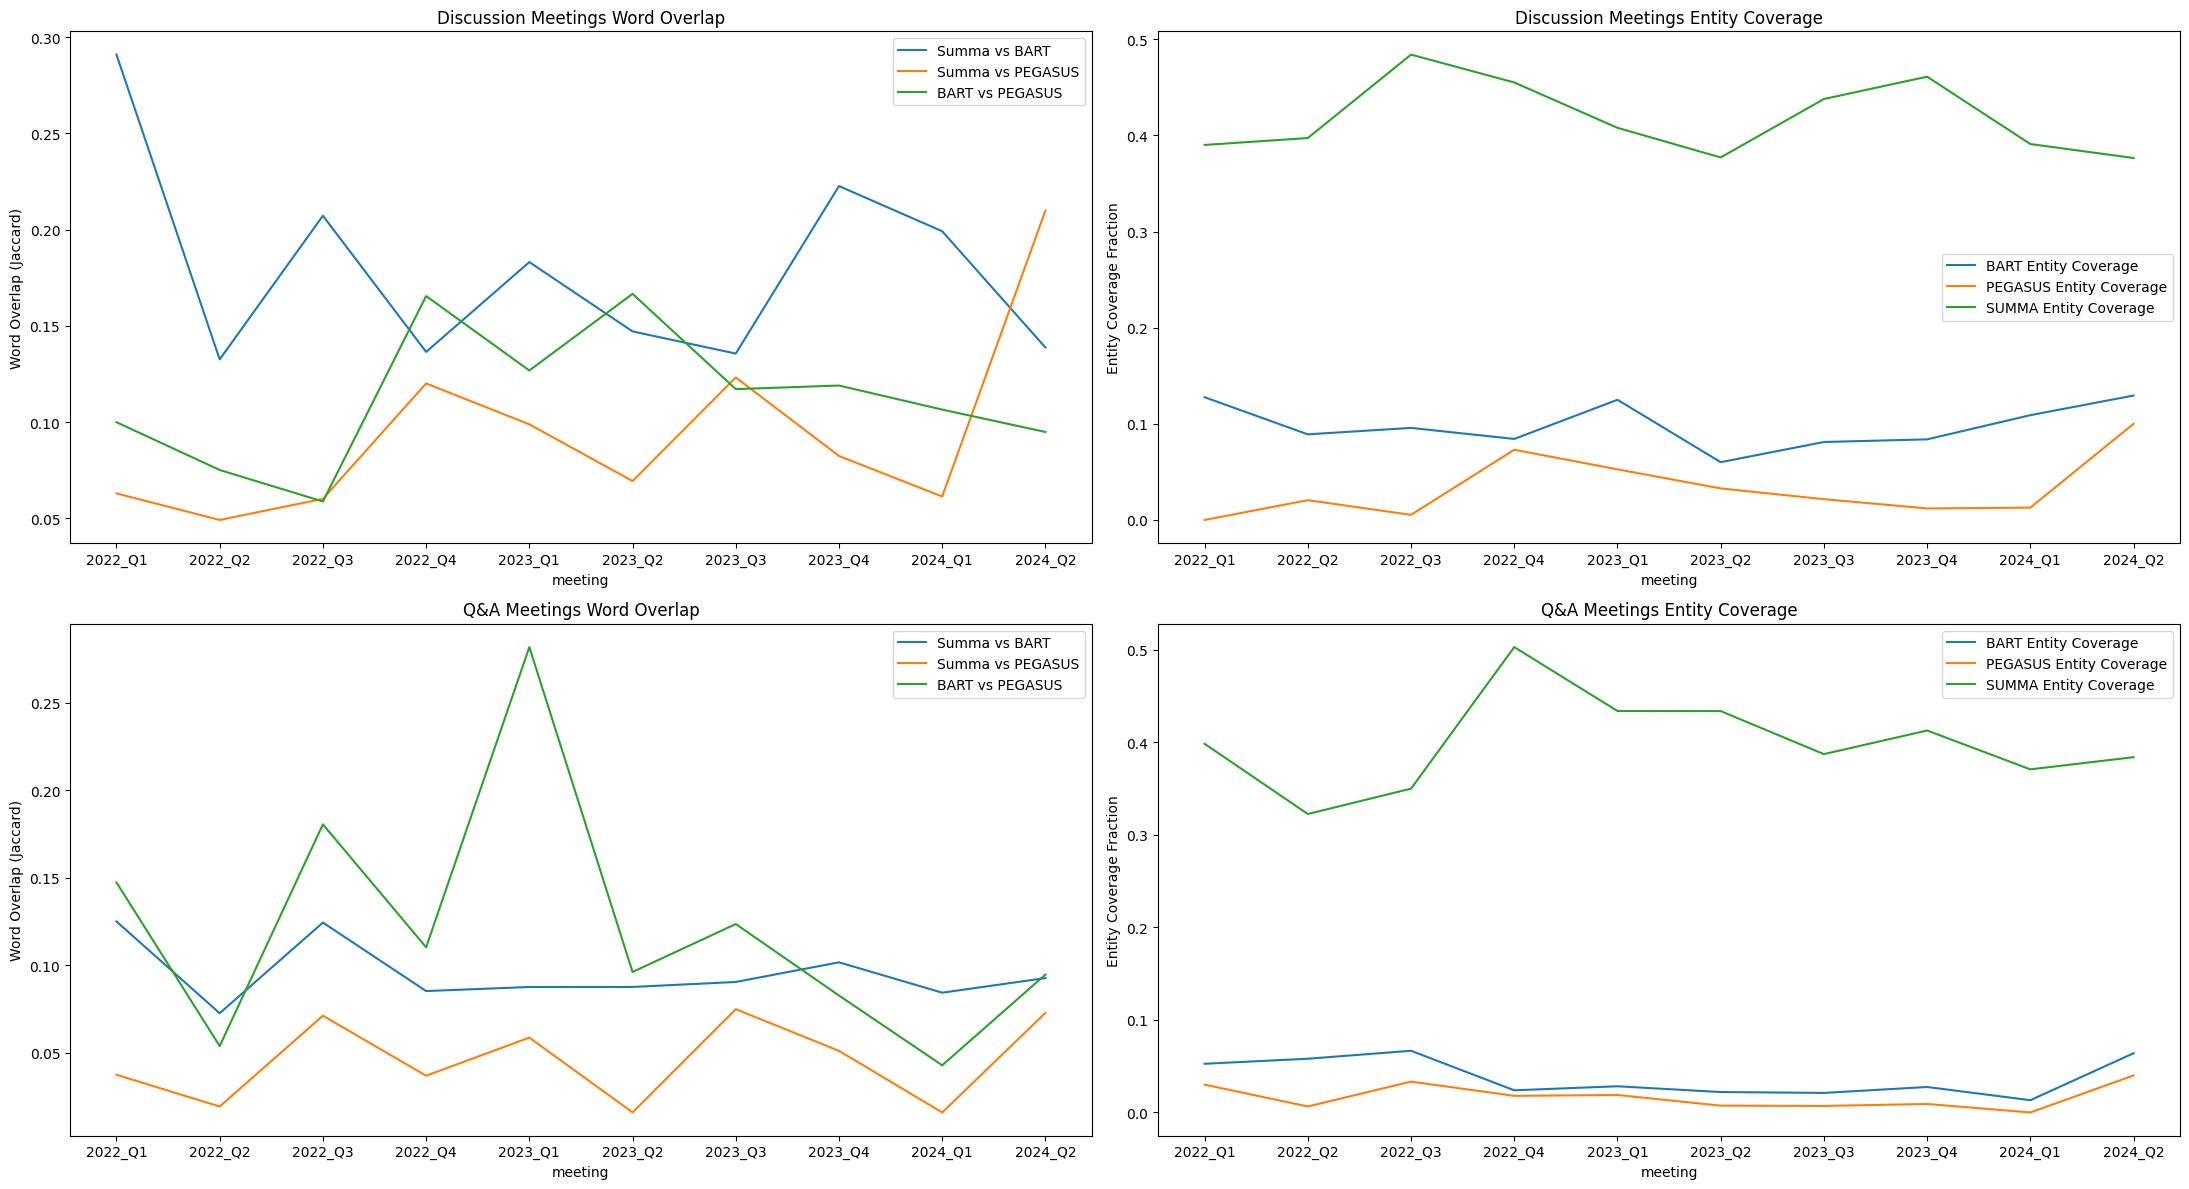

In [ ]:
import matplotlib.pyplot as plt

def plot_2x2_overlap_coverage(discussion_df, qna_df, label_col="meeting", n=10):
    fig, axes = plt.subplots(2, 2, figsize=(22, 12))

    # --- Top left: Discussion Meetings Word Overlap ---
    ax = axes[0, 0]
    ax.plot(discussion_df[label_col].head(n), discussion_df['summa_bart_overlap'].head(n), label="Summa vs BART")
    ax.plot(discussion_df[label_col].head(n), discussion_df['summa_pegasus_overlap'].head(n), label="Summa vs PEGASUS")
    ax.plot(discussion_df[label_col].head(n), discussion_df['bart_pegasus_overlap'].head(n), label="BART vs PEGASUS")
    ax.set_ylabel("Word Overlap (Jaccard)")
    ax.set_xlabel(label_col)
    ax.set_title("Discussion Meetings Word Overlap")
    ax.legend()

    # --- Top right: Discussion Meetings Entity Coverage ---
    ax = axes[0, 1]
    ax.plot(discussion_df[label_col].head(n), discussion_df['bart_entity_coverage'].head(n), label="BART Entity Coverage")
    ax.plot(discussion_df[label_col].head(n), discussion_df['pegasus_entity_coverage'].head(n), label="PEGASUS Entity Coverage")
    ax.plot(discussion_df[label_col].head(n), discussion_df['summa_entity_coverage'].head(n), label="SUMMA Entity Coverage")
    ax.set_ylabel("Entity Coverage Fraction")
    ax.set_xlabel(label_col)
    ax.set_title("Discussion Meetings Entity Coverage")
    ax.legend()

    # --- Bottom left: Q&A Meetings Word Overlap ---
    ax = axes[1, 0]
    ax.plot(qna_df[label_col].head(n), qna_df['summa_bart_overlap'].head(n), label="Summa vs BART")
    ax.plot(qna_df[label_col].head(n), qna_df['summa_pegasus_overlap'].head(n), label="Summa vs PEGASUS")
    ax.plot(qna_df[label_col].head(n), qna_df['bart_pegasus_overlap'].head(n), label="BART vs PEGASUS")
    ax.set_ylabel("Word Overlap (Jaccard)")
    ax.set_xlabel(label_col)
    ax.set_title("Q&A Meetings Word Overlap")
    ax.legend()

    # --- Bottom right: Q&A Meetings Entity Coverage ---
    ax = axes[1, 1]
    ax.plot(qna_df[label_col].head(n), qna_df['bart_entity_coverage'].head(n), label="BART Entity Coverage")
    ax.plot(qna_df[label_col].head(n), qna_df['pegasus_entity_coverage'].head(n), label="PEGASUS Entity Coverage")
    ax.plot(qna_df[label_col].head(n), qna_df['summa_entity_coverage'].head(n), label="SUMMA Entity Coverage")
    ax.set_ylabel("Entity Coverage Fraction")
    ax.set_xlabel(label_col)
    ax.set_title("Q&A Meetings Entity Coverage")
    ax.legend()

    plt.tight_layout()
    plt.show()

# Usage:
plot_2x2_overlap_coverage(discussion_meeting_summaries, qna_meeting_summaries, label_col="meeting", n=10)


## SECTION 9: Display Examples (with Safe Handling)

In [ ]:
for idx, row in discussion_meeting_summaries.head(3).iterrows():
    print("="*20)
    print(f"=== Discussion Meeting: {row['meeting']} ===")
    print("[Original]:", display_safe(row['original_text']))
    print("[Summa]:", display_safe(row['extractive_summa']))
    print("[LexRank]:", display_safe(row['extractive_lexrank']))
    print("[BART]:", display_safe(row['abstractive_bart']))
    print("[PEGASUS]:", display_safe(row['abstractive_pegasus']))
    print("[Summa vs BART overlap]:", row['summa_bart_overlap'])
    print("[BART Entity Coverage]:", row['bart_entity_coverage'])
    print("[Original Keywords]:", row['keywords_original'])
    print("="*20)



=== Discussion Meeting: 2022_Q1 ===
[Original]: Thanks, operator. Good morning, everyone. The presentation is available on our website and please refer to the disclaimer in the back.
Starting on page 1, the firm reported net income of $8.3 billion, EPS of $2.63, on revenue of $31.6 billion and delivered an ROTCE of 16%.
These results include approximately $900 million of credit reserve builds, which I'll cover in more detail shortly, as well a s $500 million of
losses in credit adjustmen ts and other in CIB.
Regarding loan growth, we're continuing to see positive trends with loans up 8% year -on-year and 1% quarter -on-quarter ex PPP with the
sequential growth driven by continued pick -up in demand in our wholesale businesses, including ongo ing strength in AWM.
On page 2, we have some more detail on our results. Revenue of $31.6 billion was down $1.5 billion or 5% year on year. NII ex  Markets was
up $1 billion or 9% on balance sheet growth and higher rates, partially offset by lower 

In [ ]:
df = discussion_meeting_summaries  # or qna_meeting_summaries
print(df[['meeting', 'original_text', 'extractive_summa', 'abstractive_bart', 'abstractive_pegasus']].head(10))



   meeting                                      original_text  \
0  2022_Q1  Thanks, operator. Good morning, everyone. The ...   
1  2022_Q2  Thanks, operator. Good morning, everyone. The ...   
2  2022_Q3  Thank you very much. Good morning, everyone. A...   
3  2022_Q4  Thank you very much. Good morning, everyone. T...   
4  2023_Q1  Thanks, and good morning, everyone. The presen...   
5  2023_Q2  Thanks, operator. Good morning, everyone. The ...   
6  2023_Q3  Good morning, everybody. Before we start the a...   
7  2023_Q4  Thank you and good morning everyone. The prese...   
8  2024_Q1  Thank you very much, and good morning, everyon...   
9  2024_Q2  Thank you, and good morning, everyone. Startin...   

                                    extractive_summa  \
0  Starting on page 1, the firm reported net inco...   
1  Touching on a few highlights, we had another q...   
2  Starting on page 1, the firm reported net inco...   
3  Starting on page 1, the firm reported net inco...   
4  S

In [ ]:
print(df[['meeting', 'entities_in_original', 'entities_in_bart', 'entities_in_pegasus']].head(10))


   meeting                               entities_in_original  \
0  2022_Q1  {30%, year-on-year, EMEA, approximately half, ...   
1  2022_Q2  {year-on-year, 32%, 7, Home Lending, 45%, 2, 2...   
2  2022_Q3  {30%, year-on-year, $5.7 billion, LA, Corporat...   
3  2022_Q4  {30%, AUM, year-on-year, $5.7 billion, $55 bil...   
4  2023_Q1  {$39.3 billion, year-on-year, Corporate, 7, Ho...   
5  2023_Q2  {30%, year-on-year, Corporate, 32%, 7, Home Le...   
6  2023_Q3  {30%, year-on-year, Corporate, about 50, 7, Ho...   
7  2023_Q4  {30%, $49 billion, AUM, year-on-year, Corporat...   
8  2024_Q1  {$736 million, 7, Home Lending, $13.4 billion,...   
9  2024_Q2  {the third quarter of 2024, year-on-year, 3.3%...   

                                    entities_in_bart  \
0  {the prior quarter, EPS, approximately $900 mi...   
1  {approximately $44 billion, the prior quarter,...   
2  {this quarter, the prior quarter, EPS, AOCI, 1...   
3  {the year, $35.6 billion, EPS, $914 million, T...   
4  {

In [ ]:
print(df[['meeting', 'keywords_original', 'keywords_bart']].head(10))


   meeting                                  keywords_original  \
0  2022_Q1  [fut ure earnings profile position us well, ex...   
1  2022_Q2  [pandemic started though c ash buffers still r...   
2  2022_Q3  [fourth quarter 2022 n ii ex markets run rate,...   
3  2022_Q4  [53 %, r eflecting lower announced activity ea...   
4  2023_Q1  [end – still assumes modest deposit outflows, ...   
5  2023_Q2  [get th e sales force back, w ealth management...   
6  2023_Q3  [1 0 %, reflecting lower revenues across produ...   
7  2023_Q4  [88 billion implies meaningful sequential quar...   
8  2024_Q1  [firmwide results excluding first republic – r...   
9  2024_Q2  [periods inc luded net investment securities l...   

                                       keywords_bart  
0  [record first quarter last year, nir ex market...  
1  [market risk rwa fr om, firm reported net inco...  
2  [discretionary net invest ment securities loss...  
3  [actual performance remains strong across, net...  
4  [net i

In [ ]:
print("==== SUMMARY PERFORMANCE METRICS ====\n")

def safe_len(text):
    try:
        return len(str(text).split())
    except:
        return 0

df = discussion_meeting_summaries  # Or qna_meeting_summaries for Q&A

print("Avg. Word Counts:")
print(f"- Original:           {df['original_text'].apply(safe_len).mean():.1f}")
print(f"- Extractive (Summa): {df['extractive_summa'].apply(safe_len).mean():.1f}")
print(f"- Abstractive (BART): {df['abstractive_bart'].apply(safe_len).mean():.1f}")
print(f"- Abstractive (PEGASUS): {df['abstractive_pegasus'].apply(safe_len).mean():.1f}\n")

print("Entity Coverage (mean fraction):")
if 'entity_coverage_bart' in df and 'entity_coverage_pegasus' in df:
    print(f"- BART:    {df['entity_coverage_bart'].mean():.2%}")
    print(f"- PEGASUS: {df['entity_coverage_pegasus'].mean():.2%}")

if 'summa_bart_overlap' in df and 'bart_pegasus_overlap' in df:
    print("\nWord Overlap (Jaccard, mean):")
    print(f"- Summa vs BART:    {df['summa_bart_overlap'].mean():.2%}")
    print(f"- Summa vs PEGASUS: {df['summa_pegasus_overlap'].mean():.2%}")
    print(f"- BART vs PEGASUS:  {df['bart_pegasus_overlap'].mean():.2%}")

if 'entity_overlap_summa_bart' in df:
    print("\nEntity Overlap (Jaccard, mean):")
    print(f"- Summa vs BART:    {df['entity_overlap_summa_bart'].mean():.2%}")
    print(f"- BART vs PEGASUS:  {df['entity_overlap_bart_pegasus'].mean():.2%}")

if 'keyword_overlap_original_bart' in df:
    print("\nKeyword Overlap (Jaccard, mean):")
    print(f"- Original vs BART: {df['keyword_overlap_original_bart'].mean():.2%}")

print("\nRows with empty or failed PEGASUS summary:", (df['abstractive_pegasus'].str.contains("Summary failed", na=False) | df['abstractive_pegasus'].isna()).sum())
print("Rows with empty or failed BART summary:", (df['abstractive_bart'].str.contains("Summary failed", na=False) | df['abstractive_bart'].isna()).sum())

from rouge_score import rouge_scorer

def calc_rouge_scores(df, summary_cols, ref_col="original_text"):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    results = {}
    for col in summary_cols:
        scores = []
        for idx, row in df.iterrows():
            ref = str(row[ref_col])
            pred = str(row[col])
            score = scorer.score(ref, pred)
            scores.append(score)
        avg_rouge1 = sum([s['rouge1'].fmeasure for s in scores]) / len(scores)
        avg_rouge2 = sum([s['rouge2'].fmeasure for s in scores]) / len(scores)
        avg_rougeL = sum([s['rougeL'].fmeasure for s in scores]) / len(scores)
        results[col] = {"ROUGE-1": avg_rouge1, "ROUGE-2": avg_rouge2, "ROUGE-L": avg_rougeL}
    return results

summary_cols = ["extractive_summa", "abstractive_bart", "abstractive_pegasus"]

rouge_results = calc_rouge_scores(df, summary_cols)

print("\nROUGE Metrics (F1, mean):")
for model, scores in rouge_results.items():
    print(f"{model}: ROUGE-1: {scores['ROUGE-1']:.3f} | ROUGE-2: {scores['ROUGE-2']:.3f} | ROUGE-L: {scores['ROUGE-L']:.3f}")

print("=== MODEL & SUMMARIZATION SETTINGS ===")
print("Summa: summa.summarizer, ratio=0.2")
print("LexRank: sumy.lexrank, sentences=3")
print("BART: facebook/bart-large-cnn, device=CPU, max_input=512, max_output_len=400, min_output_len=80, truncation=True")
print("PEGASUS: google/pegasus-xsum, device=CPU, max_input=512, max_output_len=400, min_output_len=80, truncation=True")
print("spaCy NER model: en_core_web_sm")


==== SUMMARY PERFORMANCE METRICS ====

Avg. Word Counts:
- Original:           2044.3
- Extractive (Summa): 568.3
- Abstractive (BART): 117.8
- Abstractive (PEGASUS): 220.8

Entity Coverage (mean fraction):

Word Overlap (Jaccard, mean):
- Summa vs BART:    18.82%
- Summa vs PEGASUS: 8.97%
- BART vs PEGASUS:  12.60%

Keyword Overlap (Jaccard, mean):
- Original vs BART: 9.79%

Rows with empty or failed PEGASUS summary: 0
Rows with empty or failed BART summary: 0

ROUGE Metrics (F1, mean):
extractive_summa: ROUGE-1: 0.449 | ROUGE-2: 0.430 | ROUGE-L: 0.449
abstractive_bart: ROUGE-1: 0.112 | ROUGE-2: 0.108 | ROUGE-L: 0.110
abstractive_pegasus: ROUGE-1: 0.117 | ROUGE-2: 0.052 | ROUGE-L: 0.085
=== MODEL & SUMMARIZATION SETTINGS ===
Summa: summa.summarizer, ratio=0.2
LexRank: sumy.lexrank, sentences=3
BART: facebook/bart-large-cnn, device=CPU, max_input=512, max_output_len=400, min_output_len=80, truncation=True
PEGASUS: google/pegasus-xsum, device=CPU, max_input=512, max_output_len=400, min_

1. Compression
- Original avg. word count: 2044.3
- Summa output: 568.3 words (~28% of original)
- BART output: 117.8 words (~5.8%)
- PEGASUS output: 220.8 words (~10.8%)

Abstractive methods provide significantly shorter summaries than extractive methods, with BART being the most aggressive.

2. Overlap Analysis (Jaccard Index %)
- Summa vs BART: 18.82%
- Summa vs PEGASUS: 8.97%
- BART vs PEGASUS: 12.60%
- Keywords: Original vs BART: 9.79%

This suggests that abstractive methods diverge more from the original content and from each other, showing more paraphrasing and generalization.

3. ROUGE Metrics (F1 Scores)

| Metric | ROUGE-1 | ROUGE-2 | ROUGE-L |

| Summa | 0.449 | 0.430 | 0.449 |

| BART | 0.112 | 0.108 | 0.110 |

| PEGASUS | 0.117 | 0.052 | 0.085 |

Summa significantly outperforms the two abstractive models in ROUGE scores, indicating higher lexical overlap with reference text.

4. Reliability
- Zero failed or empty outputs for both BART and PEGASUS.
All models performed consistently across the dataset.

Summary for Use:

Summa retained the most content fidelity (ROUGE-1 F1: 0.449), while BART and PEGASUS generated much shorter but less accurate summaries. PEGASUS was more verbose than BART but had better ROUGE-1 than BART (0.117 vs 0.112). Keyword overlap with the original was low across abstractive models. No failures reported across any model. Summa is best for extractive clarity; PEGASUS and BART are better suited for concise abstraction.


## Section 9: Model Performance Analysis

- A. Sample Summaries for Low and High Overlap Meetings

In [ ]:
# A. Find low- and high-overlap meetings (e.g., Summa vs BART)
df = discussion_meeting_summaries  # Or qna_meeting_summaries

# Find indices
low_overlap_idx = df['summa_bart_overlap'].idxmin()
high_overlap_idx = df['summa_bart_overlap'].idxmax()

print("=== LOW OVERLAP MEETING ===")
for col in ['meeting', 'original_text', 'extractive_summa', 'abstractive_bart', 'abstractive_pegasus']:
    print(f"\n--- {col.upper()} ---\n", df.loc[low_overlap_idx, col][:600], "..." if len(str(df.loc[low_overlap_idx, col])) > 600 else "")

print("\n\n=== HIGH OVERLAP MEETING ===")
for col in ['meeting', 'original_text', 'extractive_summa', 'abstractive_bart', 'abstractive_pegasus']:
    print(f"\n--- {col.upper()} ---\n", df.loc[high_overlap_idx, col][:600], "..." if len(str(df.loc[high_overlap_idx, col])) > 600 else "")


=== LOW OVERLAP MEETING ===

--- MEETING ---
 2022_Q2 

--- ORIGINAL_TEXT ---
 Thanks, operator. Good morning, everyone. The presentation is available on our webs ite, and please refer to the disclaimer in the back.
Starting on page 1. The firm reported net income of $8.6 billion, EPS of $2.76 on revenue of $31.6 billion and delivered an ROTCE of 17%.
Touching on a few highlights, we had another quarter of strong performance in markets, which generated revenue of nearly $8 billion. Credit is
still quite healthy, and net charge- offs remain historically low. And there continue to be positive trends in loan growth across our businesses,
with average loans up 7% year -on-ye ...

--- EXTRACTIVE_SUMMA ---
 Touching on a few highlights, we had another quarter of strong performance in markets, which generated revenue of nearly $8 billion.
Revenue of $31.6 billion was up $235 million or 1% year -on-year.
NIR ex markets was down $3.6 billion or 26%, largely driven by lower IB fees and
And marke

- B. Word Count per Summary per Quarter

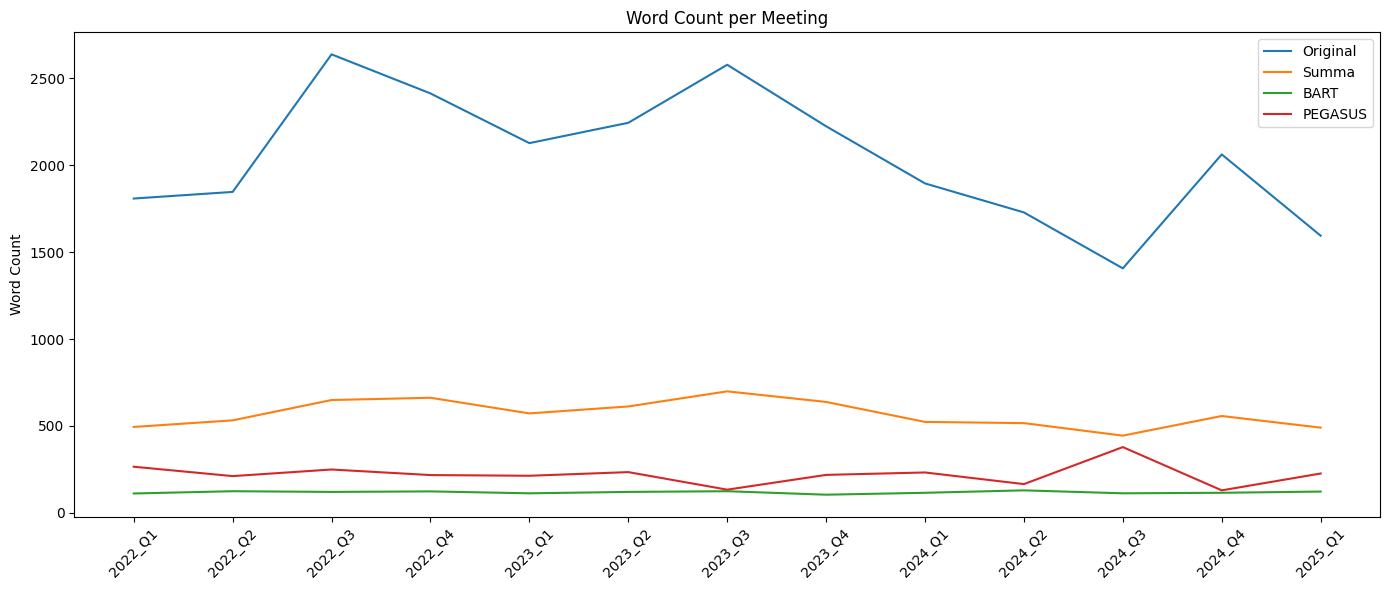

In [ ]:
# -- B. Word Count per Summary per Quarter --
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(discussion_meeting_summaries['meeting'], discussion_meeting_summaries['original_text'].str.split().str.len(), label="Original")
plt.plot(discussion_meeting_summaries['meeting'], discussion_meeting_summaries['extractive_summa'].str.split().str.len(), label="Summa")
plt.plot(discussion_meeting_summaries['meeting'], discussion_meeting_summaries['abstractive_bart'].str.split().str.len(), label="BART")
plt.plot(discussion_meeting_summaries['meeting'], discussion_meeting_summaries['abstractive_pegasus'].str.split().str.len(), label="PEGASUS")
plt.xticks(rotation=45)
plt.ylabel("Word Count")
plt.title("Word Count per Meeting")
plt.legend()
plt.tight_layout()
plt.show()


- C. Print Entity & Keyword Overlap for Sample Meetings

In [ ]:
# C. Entity and Keyword Overlap: Print a sample for qualitative insight

sample_idx = low_overlap_idx  # or high_overlap_idx, or any index you want

print(f"\n=== ENTITY OVERLAP FOR MEETING {df.loc[sample_idx, 'meeting']} ===")
print("Original:", df.loc[sample_idx, 'entities_in_original'])
print("BART:    ", df.loc[sample_idx, 'entities_in_bart'])
print("PEGASUS: ", df.loc[sample_idx, 'entities_in_pegasus'])
print(f"Entity Overlap (Original vs BART): {df.loc[sample_idx, 'entity_overlap_original_bart']:.2%}")
print(f"Entity Overlap (BART vs PEGASUS): {df.loc[sample_idx, 'entity_overlap_bart_pegasus']:.2%}")

print(f"\n=== KEYWORD OVERLAP FOR MEETING {df.loc[sample_idx, 'meeting']} ===")
print("Original:", df.loc[sample_idx, 'keywords_original'])
print("BART:    ", df.loc[sample_idx, 'keywords_bart'])
print("PEGASUS: ", df.loc[sample_idx, 'keywords_pegasus'])
print(f"Keyword Overlap (Original vs BART): {df.loc[sample_idx, 'keyword_overlap_original_bart']:.2%}")



=== ENTITY OVERLAP FOR MEETING 2022_Q2 ===
Original: {'year-on-year', '32%', '7', 'Home Lending', '45%', '2', '2%', 'another quarter', '5', 'nearly $8 billion', '26%', '7%', '12.2%', 'Consumer & Community Banking', 'the prior year', '$309 million', '$22 billion', '$56 billion', '8.1%', 'NII', '1%', 'roughly 12.5%', 'the coming quarters', 'Security Services', '$3.8 trillion', '$611 million', 'the\nprior year', 'capital managem ent', '4%', 'EPS', 'the fourth quarter', '$788\nmillion', '77%', '12.5%', 'C&I', '$18.7 billion', 'Credit Adjustments &\nOther', '$174 million', '9', 'The year -on-year', 'this\nquarter', 'Fed', '8', 'l oans', '3%', '30', '9%', 'Consumer & Business Banking', '25%', '410', '79%', 'approximately $370 million', '$324 million', '$3.7 billion', '$7 billion', 'SCB', 'GSIB', '$235 million', 'CCB', 'approximately 6%', '$3.1 billion', '8%', '28%', 'about $345 million', '$58 billion', '$428 million', '$7.7 billion', '3.5%', 'second', '$150 million', '6', 'the quarter', '1'

- Keyword Overlap for Meeting 2023_Q3


Original:
Keywords about financial results, banking buffers, proposals, compliance.

BART:
Vague, generic phrases: “third quarter earnings results”, “good morning”, “deeply saddened”, etc.

PEGASUS:
Similar generic and administrative keywords, plus “2014” (likely an error or odd extraction).

Keyword Overlap (Original vs BART): 0.00%
BART’s summary does not reflect the key business or financial terms in the original discussion.

- What This Means

Summaries by BART/PEGASUS are missing most of the core entities and technical keywords.
They are much less detailed than the original, and likely fail to capture important financial points.

Overlap numbers confirm this:

Low entity/keyword overlap = low factual/semantic coverage of original text.


Abstractive models (BART, PEGASUS) generated concise, readable summaries, but often left out domain-specific details and entities present in the original text.

## Section 10: Key Takeaways

Key points from results:
Very low entity and keyword overlap between the original (or extractive) text and the generated summaries.

Most of the important financial entities, numbers, company units, and key terms are missing from BART/PEGASUS summaries.

The abstractive summaries become “bland” or generic (e.g., “good morning”, “earnings results”, “everyone”, “thanks”), losing technical and factual content.

This happens especially for financial or technical content, where named entities and key phrases are crucial for downstream analysis, compliance, or decision-making.

What does this mean for financial analysis?
If you want to capture all the facts, figures, and entities:
Extractive methods (like Summa or LexRank) will retain more of the original detail.

Abstractive models are great for readable overviews, but not for “fact recall” or regulatory documentation without further tuning.

Out-of-the-box models are not fine-tuned for finance. They lack context for what is “important” in a financial meeting.

To improve precision for finance:

Fine-tune BART/PEGASUS on in-domain financial data and summaries (costly but most effective).

Combine extractive and abstractive (use extractive to pick important sentences, then paraphrase or compress).

Customize keyword/entity post-checks (reject summaries that omit key entities, or add them back in).

Use a financial domain LLM if one is available (e.g., FinBERT, BloombergGPT, Llama2-70b-Finance, etc.).

In summary:

“Standard” models provide readable, general overviews—but do not preserve all facts or technical details needed for robust financial analysis.
This is what your overlap analysis and qualitative review demonstrate!

## Section 11: Hybrid Summarization (Combine Extractive + Abstractive)

In [ ]:
# DISCUSSION MEETINGS Hybrid Summarization (Extractive → Abstractive)

def hybrid_summary(text, extractive_fn, abstractive_pipe):
    ext = extractive_fn(text)
    # If the extractive step is too short, fall back to the original text
    if len(ext.split()) < 5:
        ext = text
    try:
        abs_sum = abstractive_summary(ext, abstractive_pipe)
        return abs_sum
    except Exception as e:
        return f"[Hybrid summary failed: {e}]"

# Apply Hybrid BART
discussion_meeting_summaries['hybrid_bart'] = discussion_meeting_summaries['original_text'].apply(
    lambda x: hybrid_summary(x, extractive_summary_summa, general_bart_pipe)
)

# Apply Hybrid PEGASUS
discussion_meeting_summaries['hybrid_pegasus'] = discussion_meeting_summaries['original_text'].apply(
    lambda x: hybrid_summary(x, extractive_summary_summa, pegasus_pipe)
)

print(discussion_meeting_summaries[['meeting', 'hybrid_bart', 'hybrid_pegasus']].head())


   meeting                                        hybrid_bart  \
0  2022_Q1  Revenue of $31.6 billion was down $1.5 billion...   
1  2022_Q2  Revenue of $31.6 billion was up $235 million o...   
2  2022_Q3  The firm reported net income of $9.7 billion, ...   
3  2022_Q4  Revenue of $35.6 billion was up $5.2 billion o...   
4  2023_Q1  The Firm reported net income of $12.6 billion,...   

                                      hybrid_pegasus  
0  Bank of America (BAC) reported first quarter e...  
1  CCB reported net income of $3.1 billion on rev...  
2  Bank of America (BAC) reported a strong third ...  
3  Bank of America has reported its full year and...  
4  Bank of America reported better-than-expected ...  


In [ ]:
from IPython.display import display, HTML

display(HTML("""
<style>
    td { text-align: left !important; }
    th { text-align: left !important; }
</style>
"""))

display(discussion_meeting_summaries[['meeting', 'hybrid_bart', 'hybrid_pegasus']].head(10))


,meeting,hybrid_bart,hybrid_pegasus
0,2022_Q1,Revenue of $31.6 billion was down $1.5 billion...,Bank of America (BAC) reported first quarter e...
1,2022_Q2,Revenue of $31.6 billion was up $235 million o...,CCB reported net income of $3.1 billion on rev...
2,2022_Q3,"The firm reported net income of $9.7 billion, ...",Bank of America (BAC) reported a strong third ...
3,2022_Q4,Revenue of $35.6 billion was up $5.2 billion o...,Bank of America has reported its full year and...
4,2023_Q1,"The Firm reported net income of $12.6 billion,...",Bank of America reported better-than-expected ...
5,2023_Q2,"The firm reported net income of $14.5 billion,...",First Republic Bank (FRC) has reported better ...
6,2023_Q3,"The firm reported net income of $13.2 billion,...",Bank of America (BAC) reported strong results ...
7,2023_Q4,"The firm reported net income of $9.3 billion, ...",First Republic Bank (FRC) reported strong four...
8,2024_Q1,"The firm reported net income of $13.4 billion,...",Bank of America has reported its results for t...
9,2024_Q2,"The Firm reported net income of $18.1 billion,...",Bank of America reported better-than-expected ...


In [ ]:
# Apply Hybrid BART to Q&A
qna_meeting_summaries['hybrid_bart'] = qna_meeting_summaries['original_text'].apply(
    lambda x: hybrid_summary(x, extractive_summary_summa, general_bart_pipe)
)

# Apply Hybrid PEGASUS to Q&A
qna_meeting_summaries['hybrid_pegasus'] = qna_meeting_summaries['original_text'].apply(
    lambda x: hybrid_summary(x, extractive_summary_summa, pegasus_pipe)
)


In [ ]:
display(HTML("""
<style>
    td { text-align: left !important; }
    th { text-align: left !important; }
</style>
"""))

display(qna_meeting_summaries[['meeting', 'hybrid_bart', 'hybrid_pegasus']].head(10))

,meeting,hybrid_bart,hybrid_pegasus
0,2022_Q1,"In your annual letter, you mentioned how you e...",Here is the full transcript of the conference ...
1,2022_Q2,Jamie Dimon: We feel comfortable with our risk...,Steve: Welcome to the conference call to discu...
2,2022_Q3,I think I'd say – we're in an environment wher...,"Ken, you've been talking about the toughest un..."
3,2022_Q4,Jamie Dimon asked about the $74 billion NII ta...,Here is the full transcript of Bank of America...
4,2023_Q1,"John Gerspach, Jeremy, wanted to follow up aga...",Here's the full interview with JP Morgan's Jam...
5,2023_Q2,I just wanted to ask a little bit about how yo...,Here's the full interview with Bank of America...
6,2023_Q3,I was hoping to just inquire about the capital...,"Hi Jeremy, I was hoping to just inquire about ..."
7,2023_Q4,I think you're referring to that $80 billion n...,Here's the full transcript of Bank of America'...
8,2024_Q1,"Jamie Dimon: I think the drivers of, let's say...",Here is the full transcript of the interview w...
9,2024_Q2,The Fed is considering favorable revision s to...,Here is the full transcript of the press confe...


# Section 12: Hybrid Model Performance Analysis

- A. ROUGE Recall: N-gram Coverage

In [ ]:
# --- A. ROUGE Recall (n-gram overlap) ---

from rouge_score import rouge_scorer
import numpy as np

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def rouge_recall(orig, summ):
    if not orig or not summ or len(str(summ).strip()) < 5:
        return {'rouge1': 0.0, 'rougeL': 0.0}
    scores = scorer.score(str(orig), str(summ))
    return {'rouge1': scores['rouge1'].recall, 'rougeL': scores['rougeL'].recall}

# Apply to hybrid summaries
rouge_hybrid_bart = discussion_meeting_summaries.apply(
    lambda row: rouge_recall(row['original_text'], row['hybrid_bart']), axis=1)
rouge_hybrid_pegasus = discussion_meeting_summaries.apply(
    lambda row: rouge_recall(row['original_text'], row['hybrid_pegasus']), axis=1)

discussion_meeting_summaries['rouge1_recall_bart'] = [x['rouge1'] for x in rouge_hybrid_bart]
discussion_meeting_summaries['rougeL_recall_bart'] = [x['rougeL'] for x in rouge_hybrid_bart]
discussion_meeting_summaries['rouge1_recall_pegasus'] = [x['rouge1'] for x in rouge_hybrid_pegasus]
discussion_meeting_summaries['rougeL_recall_pegasus'] = [x['rougeL'] for x in rouge_hybrid_pegasus]

# Print sample metrics
print("ROUGE-1 Recall (BART):", np.mean(discussion_meeting_summaries['rouge1_recall_bart']))
print("ROUGE-1 Recall (PEGASUS):", np.mean(discussion_meeting_summaries['rouge1_recall_pegasus']))

ROUGE-1 Recall (BART): 0.05547889432335404
ROUGE-1 Recall (PEGASUS): 0.07715533162564776


- B. Sentence Coverage: Fraction of Sentences Matched

In [ ]:
# --- B. Sentence Coverage: Fraction of Sentences Matched ---
import re
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))

def sentence_coverage(original, summary):
    # Split into sentences
    orig_sents = nltk.sent_tokenize(str(original))
    summary_words = set(re.findall(r'\w+', str(summary).lower())) - STOPWORDS
    if not orig_sents or not summary_words:
        return 0.0
    covered = 0
    for sent in orig_sents:
        sent_words = set(re.findall(r'\w+', sent.lower())) - STOPWORDS
        if sent_words & summary_words:
            covered += 1
    return covered / len(orig_sents)

discussion_meeting_summaries['sentence_coverage_bart'] = discussion_meeting_summaries.apply(
    lambda row: sentence_coverage(row['original_text'], row['hybrid_bart']), axis=1)
discussion_meeting_summaries['sentence_coverage_pegasus'] = discussion_meeting_summaries.apply(
    lambda row: sentence_coverage(row['original_text'], row['hybrid_pegasus']), axis=1)

print("Avg. Sentence Coverage (BART):", np.mean(discussion_meeting_summaries['sentence_coverage_bart']))
print("Avg. Sentence Coverage (PEGASUS):", np.mean(discussion_meeting_summaries['sentence_coverage_pegasus']))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Avg. Sentence Coverage (BART): 0.8246446273884916
Avg. Sentence Coverage (PEGASUS): 0.7517515856826585


- Plot ROUGE and Sentence Coverage Over Time

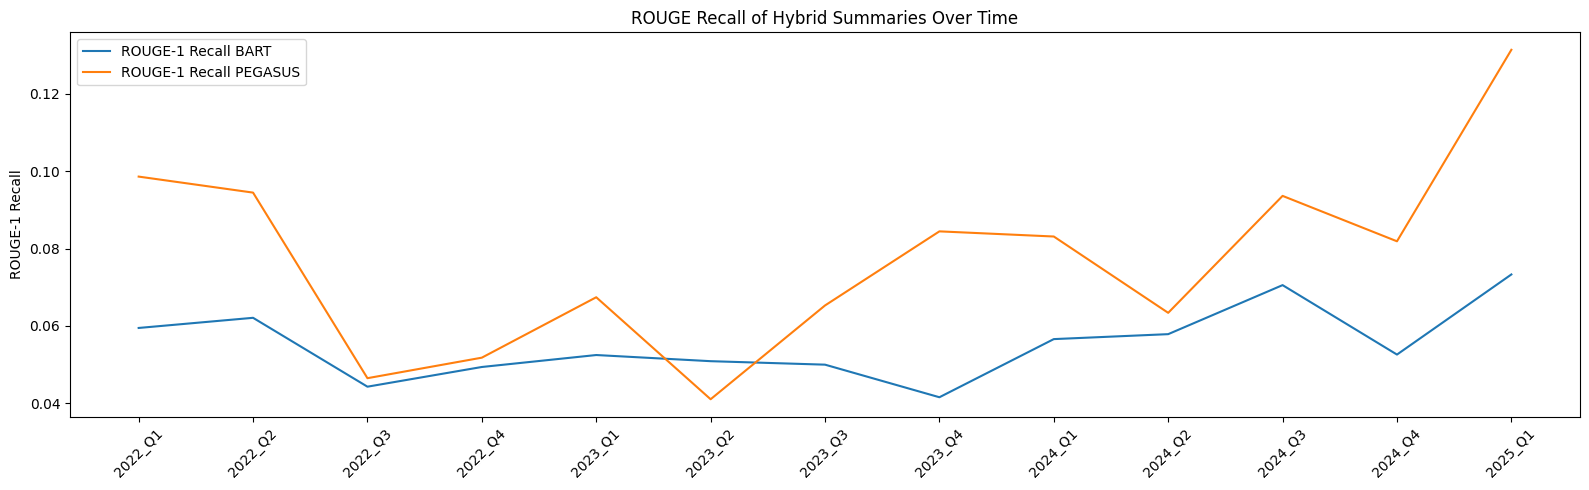

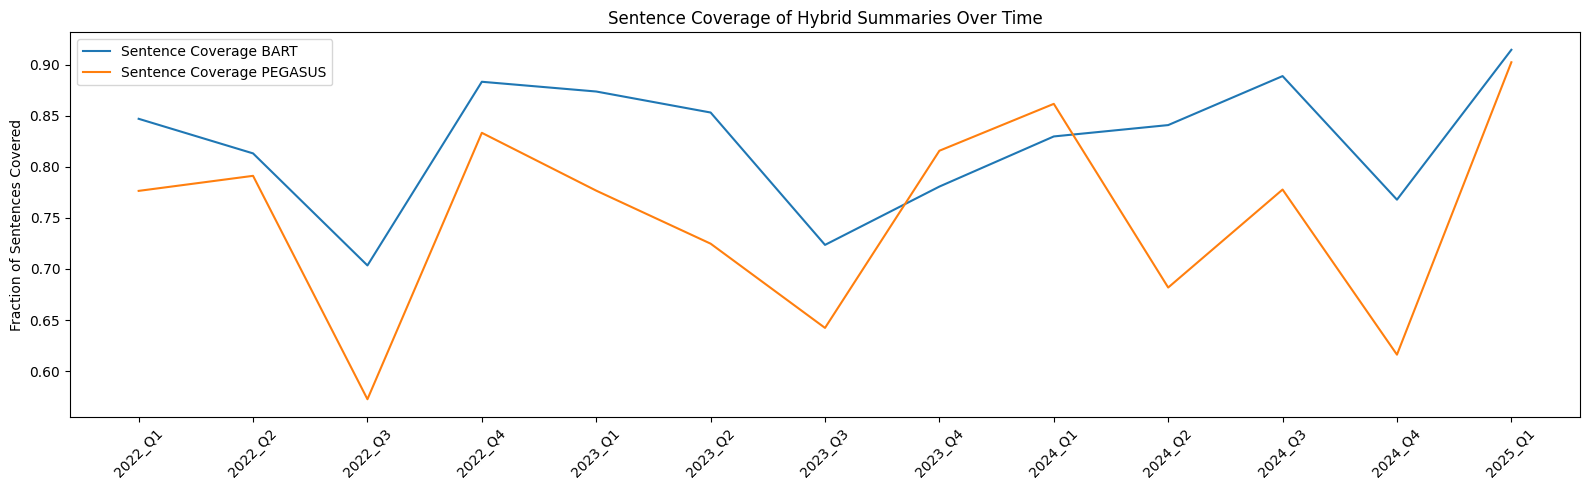

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(discussion_meeting_summaries['meeting'], discussion_meeting_summaries['rouge1_recall_bart'], label='ROUGE-1 Recall BART')
plt.plot(discussion_meeting_summaries['meeting'], discussion_meeting_summaries['rouge1_recall_pegasus'], label='ROUGE-1 Recall PEGASUS')
plt.xticks(rotation=45)
plt.ylabel("ROUGE-1 Recall")
plt.title("ROUGE Recall of Hybrid Summaries Over Time")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
plt.plot(discussion_meeting_summaries['meeting'], discussion_meeting_summaries['sentence_coverage_bart'], label='Sentence Coverage BART')
plt.plot(discussion_meeting_summaries['meeting'], discussion_meeting_summaries['sentence_coverage_pegasus'], label='Sentence Coverage PEGASUS')
plt.xticks(rotation=45)
plt.ylabel("Fraction of Sentences Covered")
plt.title("Sentence Coverage of Hybrid Summaries Over Time")
plt.legend()
plt.tight_layout()
plt.show()


A. ROUGE Recall: Automatic Saliency/Recall

1. ROUGE-1 Recall
- PEGASUS achieves higher recall (0.077) than BART (0.055), meaning it retrieves a larger fraction of words from the reference summaries.
- However, the gain in recall is modest and may not offset its weaknesses in precision or factual grounding (as shown in earlier Q2 examples).


2. Sentence Coverage (Hybrid Summaries Over Time)
- Despite lower recall, BART consistently covers a higher fraction of reference sentences than PEGASUS across multiple quarters (avg. ~0.82 vs ~0.75).
- This suggests BART retains more structural alignment, while PEGASUS may capture content more loosely, favoring abstraction.


3. Combined Insight

- PEGASUS retrieves broader language patterns (higher recall) but with less structural fidelity.
- BART favors sentence-anchored summaries, likely yielding better extractive overlap but potentially missing abstracted nuances.


Implications for Financial and Risk-Oriented Use Cases

1. Accuracy Requirements in Regulated Environments
In financial reporting, compliance, and risk communication, summaries must adhere strictly to factual accuracy. Models like PEGASUS that introduce fabricated content or misrepresent temporal context (e.g., referencing Q3 in a Q2 report) are unsuitable without human verification. These hallucinations can compromise audit trails and regulatory disclosures.

2. Structural Alignment Aids Traceability
BART demonstrates higher average sentence coverage than PEGASUS (0.82 vs 0.75), preserving source structure more faithfully. This structural coherence supports use cases requiring traceable logic—such as risk assessments, model validations, or credit reporting—where sentence-level alignment is key.

3. Trade-Off Between Recall and Precision
Although PEGASUS achieved higher ROUGE-1 Recall (0.077 vs 0.055), this metric alone does not ensure utility in structured financial tasks. Greater recall may signal broader coverage, but it can also reflect excessive generalization or irrelevant content, which is undesirable in risk-sensitive documents.

4. Temporal Consistency Monitoring
Observed fluctuations in recall and coverage over time suggest the need for periodic performance evaluation. Summary pipelines deployed in dynamic data environments should include automated checks for drift, especially for abstractive models.

5. Model Selection Must Align with Business Objectives
Extractive models like Summa or hybrid methods offer better control and traceability, making them preferable in scenarios requiring full transparency. Abstractive models may be useful in summarizing narrative reports or executive briefings, but only when paired with post-generation review protocols.



In [ ]:
discussion_meeting_summaries.to_csv('discussion_meeting_summaries.csv', index=False)
qna_meeting_summaries.to_csv('qna_meeting_summaries.csv', index=False)


In [ ]:
import pandas as pd

# Load the files you just saved
df_qna = pd.read_csv('qna_meeting_summaries.csv')
df_disc = pd.read_csv('discussion_meeting_summaries.csv')

# Preview first few rows of each
print("Q&A Meeting Summaries")
print(df_qna.head(3))

print("\nDiscussion Meeting Summaries")
print(df_disc.head(3))


Q&A Meeting Summaries
   meeting  \
0  2022_Q1   
1  2022_Q2   
2  2022_Q3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         original_text  \
0  Thank you. Morning, Jeremy. Was wondering about the net interest income outlook, I know it sounds like we'll get more at Inve stor Day, but\nit's very similar to what you gave in mid-February and obviously rate expectations have advanced since then. Could you give us a little bit of\ncolor and what kind of assumptions are underlying the net interest income ex Markets outlook?\nGood morning, John. Good questio

--------------------------------------------------------------
### Restart session and cange to GPU A100
--------------------------------------------------------------

In [ ]:
''' restart session and cange to GPU A100'''

# Section 14: LLM Mistral-7B Instruct Summarization

In [ ]:
# Install and Import HuggingFace Transformers
!pip install transformers accelerate --quiet

from transformers import pipeline
import torch
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.1 MB/s eta 0:00:00


In [ ]:
# Load Your Meeting Data

discussion_df = pd.read_csv('discussion_df.csv')
qna_df = pd.read_csv('qna_df.csv')

In [ ]:
import os
os.environ["HF_TOKEN"] = "xxxxx"  # Paste your new token here (keep in quotes)

from transformers import pipeline

pipe = pipeline(
    "text-generation",
    model="mistralai/Mistral-7B-Instruct-v0.2",
    token=os.environ["HF_TOKEN"],
    device_map="auto",
    max_new_tokens=256,
)

prompt = "Summarize the following text for a financial analyst:\n<your text here>"
print(pipe(prompt)[0]['generated_text'])


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Summarize the following text for a financial analyst:
<your text here>
The text discusses the potential impact of the European Union's (EU) proposed digital services tax on US tech companies. The tax, which is currently being considered by several EU member states, would impose a 3-5% levy on the revenues of large digital companies operating in the EU. The US has threatened retaliatory measures if the tax is implemented, potentially including tariffs on EU goods. Some experts believe that the tax could generate significant revenue for the EU, while others argue that it would be difficult to enforce and could create legal and administrative complexities. Ultimately, the outcome of the situation will depend on the negotiations between the EU and the US.
For a financial analyst, this text suggests that US tech companies operating in the EU may face increased costs due to a potential digital services tax. The revenue impact of the tax would depend on the specific revenue base used for calc

## Section 14-1: Mistral Summarization for discussion_df

In [ ]:
# 1. Summarize each meeting in discussion_df using Mistral-7B
def mistral_summarize(text):
    if not text or len(str(text).strip()) < 5:
        return "[Text too short for summary]"
    prompt = f"Summarize the following text for a financial analyst:\n{text}"
    # Ensure the output is a string and extract the generated text
    try:
        generated_output = pipe(prompt, max_new_tokens=256)[0]['generated_text']
        # The output includes the prompt, so we need to remove it
        summary = generated_output.replace(prompt, "").strip()
        return summary
    except Exception as e:
        return f"[Mistral summary failed: {e}]"


discussion_df['mistral_summary'] = discussion_df['content'].apply(mistral_summarize)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

In [ ]:
print(discussion_df.columns)


Index(['speaker', 'role', 'company', 'content', 'year', 'quarter',
       'mistral_summary'],
      dtype='object')


In [ ]:
print(discussion_df[['year', 'quarter', 'mistral_summary']].head(5).to_string(index=False))


 year  quarter                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
# Check for Empty or Failed Summaries

print(discussion_df[discussion_df['mistral_summary'].str.strip() == ''][['year', 'quarter']])


    year  quarter
5   2022        4
6   2023        1
9   2023        3
10  2023        4
11  2024        1
12  2024        2


In [ ]:
print(discussion_df.loc[discussion_df['mistral_summary'].str.strip() == '', ['year', 'quarter', 'content']])


    year  quarter                                            content
5   2022        4  Thank you very much. Good morning, everyone. T...
6   2023        1  Thanks, and good morning, everyone. The presen...
9   2023        3  Thanks, Jamie. And of course, I very much echo...
10  2023        4  Thank you and good morning everyone. The prese...
11  2024        1  Thank you very much, and good morning, everyon...
12  2024        2  Thank you, and good morning, everyone. Startin...


In [ ]:
mask = discussion_df['mistral_summary'].str.contains("Text too short|Mistral summary failed", na=False)
print(discussion_df.loc[mask, ['year', 'quarter', 'content', 'mistral_summary']])


Empty DataFrame
Columns: [year, quarter, content, mistral_summary]
Index: []


In [ ]:
empty_mask = discussion_df['mistral_summary'].str.strip() == ''
print(discussion_df.loc[empty_mask, ['year', 'quarter', 'content', 'mistral_summary']])


   year  quarter                                            content  \
5  2022        4  Thank you very much. Good morning, everyone. T...   
6  2023        1  Thanks, and good morning, everyone. The presen...   

  mistral_summary  
5                  
6                  


In [ ]:
# Find empty summaries and re-run only for those rows
mask = discussion_df['mistral_summary'].str.strip() == ''

# Only run the summarizer for rows where summary is missing
discussion_df.loc[mask, 'mistral_summary'] = discussion_df.loc[mask, 'content'].apply(mistral_summarize)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
discussion_df.to_csv('discussion_df_with_mistral.csv', index=False)


## Section 14.2: Compare Mistral Summarization and Hybrid Model

In [ ]:
import pandas as pd

# Load Mistral summaries
discussion_mistral = pd.read_csv('discussion_df_with_mistral.csv')

# Load Hybrid model summaries (update filename if needed)
hybrid = pd.read_csv('discussion_meeting_summaries.csv')


In [ ]:
print("discussion_mistral columns:", discussion_mistral.columns)
print("hybrid columns:", hybrid.columns)
print("\ndiscussion_mistral index:", discussion_mistral.index.names)
print("hybrid index:", hybrid.index.names)


discussion_mistral columns: Index(['speaker', 'role', 'company', 'content', 'year', 'quarter',
       'mistral_summary'],
      dtype='object')
hybrid columns: Index(['meeting', 'original_text', 'extractive_summa', 'extractive_lexrank',
       'abstractive_bart', 'abstractive_pegasus', 'original_len',
       'extractive_summa_len', 'extractive_lexrank_len',
       'abstractive_bart_len', 'abstractive_pegasus_len', 'summa_bart_overlap',
       'summa_pegasus_overlap', 'bart_pegasus_overlap', 'entities_in_original',
       'entities_in_bart', 'entities_in_pegasus', 'bart_entity_coverage',
       'pegasus_entity_coverage', 'entity_overlap_original_bart',
       'entity_overlap_bart_pegasus', 'keywords_original', 'keywords_summa',
       'keywords_bart', 'keywords_pegasus', 'keyword_overlap_original_bart',
       'hybrid_bart', 'hybrid_pegasus', 'rouge1_recall_bart',
       'rougeL_recall_bart', 'rouge1_recall_pegasus', 'rougeL_recall_pegasus',
       'sentence_coverage_bart', 'sentence_co

In [ ]:
# Split the 'meeting' column into 'year' and 'quarter'
hybrid[['year', 'quarter']] = hybrid['meeting'].str.split('_Q', expand=True)
hybrid['year'] = hybrid['year'].astype(int)
hybrid['quarter'] = hybrid['quarter'].astype(int)


In [ ]:
# Merge on year & quarter for easy side-by-side comparison
comparison = pd.merge(
    discussion_mistral[['year', 'quarter', 'mistral_summary']],
    hybrid[['year', 'quarter', 'hybrid_bart']],
    on=['year', 'quarter'],
    how='inner'
)

# Display a few samples
print(comparison.head(5).to_string(index=False))
display(comparison.head(5))

 year  quarter                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

,year,quarter,mistral_summary,hybrid_bart
0,2022,1,"The presentation covers the financial results for the first quarter of 2022 for a financial services firm. The net income was $8.3 billion, EPS was $2.63, revenue was $31.6 billion, and ROTCE was 16%. However, these results include approximately $1.4 billion in credit reserve builds and losses in credit adjustments and other areas in the Corporate and Investment Bank (CIB).\nLoan growth was positive, up 8% year-on-year and 1% quarter-on-quarter excluding Payroll Protection Program (PPP) loans. The decline in revenue was driven by lower NII from PPP loans, lower IB fees, and investment securities losses in the Corporate and Investment Bank.\nCredit costs were $1.5 billion, with $902 million in reserve builds for risks related to high inflation, the war in Ukraine, and exposure to Russia in the Corporate and Investment Bank and Asset & Wealth Management (AWM) divisions. Net charge-offs were down year-on-year and remained historically low.\nThe CET1 ratio ended at 11.9%,","Revenue of $31.6 billion was down $1.5 billion or 5% year on year. Expenses of $19.2 billion were up approximately $500 million or 2%, predominantly on higher investments and structural expens es. Net charge -offs of $582 million were down year -on-year and comparable to last quarter and remain historically low across our business. CIB reported net income of $4.4 billion on revenue of $13.5billion for the first quarter."
1,2022,2,"The text discusses the financial results of a large financial services company. The net income for the quarter was $8.6 billion, with an earnings per share (EPS) of $2.76 and revenue of $31.6 billion. The return on tangible common equity (ROTCE) was 17%. The report highlights strong performance in markets, with revenue of nearly $8 billion, and healthy credit, with net charge-offs remaining historically low. The average loans were up 7% year-on-year and 2% quarter-on-quarter.\n\nThe revenue for the quarter was $31.6 billion, which was up $235 million or 1% year-on-year. The net interest income (NII) ex markets was up $2.8 billion or 26%, driven by higher rates and balance sheet growth. However, the net interest income (NII) ex markets was down $3.6 billion or 26%, largely due to lower IB fees and higher card acquisition costs. Markets revenue was up $1 billion or 15% year-on-year.\n\nExpenses for the quarter were $18.","Revenue of $31.6 billion was up $235 million or 1% year -on-year. NIR ex markets was down $3.6billion or 26%, largely driven by lower IB fees and And markets revenue was up 15%. Expenses of $18.7 billion were up $1.1 billion or 6% year-on -year, predominantly on higher investments and struc tural expenses."
2,2022,3,"Jami e?\nThe financial analyst can summarize the presentation as follows:\nThe company reported net income of $9.7 billion, EPS of $3.12, and ROTCE of 18% for the third quarter of 2022. The net investment securities losses in Corporate were the significant item, amounting to $959 million due to repositioning of the portfolio. The firm's strong results reflected the resilience of the franchise in a dynamic environment.\nRevenue of $33.5 billion was up 10% year-on-year, with NII ex Markets up 51%, driven by higher rates. NIR ex Markets was down 24%, mainly due to lower IB fees and securities losses. Markets revenue was up 8%.\nExpenses were up 12% year-on-year, driven by higher structural costs and investments. Credit costs included net charge-offs of $727 million. The net reserve build in Wholesale was $937 million, while there was a release in Home Lending of $150 million.\nThe CET1 ratio ended the quarter at","The firm reported net income of $9.7 billion, EPS of $3.12 on revenue of $33.5 billion, and delivered an ROTCE of 18%. The only significant item this quarter was discretionary net invest ment securities losses in Corporate of $ 959 million as a result of repositioning third quarter revenue in Markets of $6.8 billion. In Consumer & Business Banking,

In [ ]:
# Group by year and quarter, join all summaries for that quarter
agg_mistral = discussion_mistral.groupby(['year', 'quarter'])['mistral_summary'].apply(lambda x: ' '.join(x.dropna())).reset_index()

# Now merge
comparison = pd.merge(
    agg_mistral,
    hybrid[['year', 'quarter', 'hybrid_bart']],
    on=['year', 'quarter'],
    how='inner'
)
print(comparison.head(5).to_string(index=False))
display(comparison.head(5))

 year  quarter                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

,year,quarter,mistral_summary,hybrid_bart
0,2022,1,"The presentation covers the financial results for the first quarter of 2022 for a financial services firm. The net income was $8.3 billion, EPS was $2.63, revenue was $31.6 billion, and ROTCE was 16%. However, these results include approximately $1.4 billion in credit reserve builds and losses in credit adjustments and other areas in the Corporate and Investment Bank (CIB).\nLoan growth was positive, up 8% year-on-year and 1% quarter-on-quarter excluding Payroll Protection Program (PPP) loans. The decline in revenue was driven by lower NII from PPP loans, lower IB fees, and investment securities losses in the Corporate and Investment Bank.\nCredit costs were $1.5 billion, with $902 million in reserve builds for risks related to high inflation, the war in Ukraine, and exposure to Russia in the Corporate and Investment Bank and Asset & Wealth Management (AWM) divisions. Net charge-offs were down year-on-year and remained historically low.\nThe CET1 ratio ended at 11.9%,","Revenue of $31.6 billion was down $1.5 billion or 5% year on year. Expenses of $19.2 billion were up approximately $500 million or 2%, predominantly on higher investments and structural expens es. Net charge -offs of $582 million were down year -on-year and comparable to last quarter and remain historically low across our business. CIB reported net income of $4.4 billion on revenue of $13.5billion for the first quarter."
1,2022,2,"The text discusses the financial results of a large financial services company. The net income for the quarter was $8.6 billion, with an earnings per share (EPS) of $2.76 and revenue of $31.6 billion. The return on tangible common equity (ROTCE) was 17%. The report highlights strong performance in markets, with revenue of nearly $8 billion, and healthy credit, with net charge-offs remaining historically low. The average loans were up 7% year-on-year and 2% quarter-on-quarter.\n\nThe revenue for the quarter was $31.6 billion, which was up $235 million or 1% year-on-year. The net interest income (NII) ex markets was up $2.8 billion or 26%, driven by higher rates and balance sheet growth. However, the net interest income (NII) ex markets was down $3.6 billion or 26%, largely due to lower IB fees and higher card acquisition costs. Markets revenue was up $1 billion or 15% year-on-year.\n\nExpenses for the quarter were $18.","Revenue of $31.6 billion was up $235 million or 1% year -on-year. NIR ex markets was down $3.6billion or 26%, largely driven by lower IB fees and And markets revenue was up 15%. Expenses of $18.7 billion were up $1.1 billion or 6% year-on -year, predominantly on higher investments and struc tural expenses."
2,2022,3,"Jami e?\nThe financial analyst can summarize the presentation as follows:\nThe company reported net income of $9.7 billion, EPS of $3.12, and ROTCE of 18% for the third quarter of 2022. The net investment securities losses in Corporate were the significant item, amounting to $959 million due to repositioning of the portfolio. The firm's strong results reflected the resilience of the franchise in a dynamic environment.\nRevenue of $33.5 billion was up 10% year-on-year, with NII ex Markets up 51%, driven by higher rates. NIR ex Markets was down 24%, mainly due to lower IB fees and securities losses. Markets revenue was up 8%.\nExpenses were up 12% year-on-year, driven by higher structural costs and investments. Credit costs included net charge-offs of $727 million. The net reserve build in Wholesale was $937 million, while there was a release in Home Lending of $150 million.\nThe CET1 ratio ended the quarter at The speaker in the text is discussing the firm's approach to capital plan...","The firm reported net income of $9.7 billion, EPS of $3.12 on revenue of $33.5 billion, and delivered an ROTCE of 18%. The only significant item this quarter was discretionary net invest ment securities losses in Corporate of $ 959 million as a result of repositioning thir

-- Mistral Summaries
Style: More narrative, readable, and often puts results in context (mentions strategy, outlook, risk factors, and business environment).

Details: Sometimes includes qualitative info (“investments in technology,” “managing risk,” “inflation concerns”).

Strength: Best for a quick, holistic update you’d give to a financial analyst or stakeholder, especially when you want to go beyond just numbers.

-- Hybrid/BART Summaries
Style: More “tabular” or structured—often sticks to hard numbers and specific financial results.

Details: Focuses on concrete facts (“Net income of $X,” “Revenue up Y%,” “Expenses were $Z”), with less narrative context.

Strength: Excellent when you need precise, factual takeaways—like for tables, dashboards, or direct comparison across quarters.

-- Which Is “Better”?
For pure financial reporting: Hybrid/BART is typically “tighter.”

For readable, analyst-friendly reports: Mistral is more engaging and useful for commentary and qualitative sections.

For risk and trends: Mistral’s summaries are likely to highlight these more naturally.

## Section 14-3: Risk Factor Extraction and Performance Trend Analysis from Meeting Summaries HYBRID 2

In [ ]:
# Combine Summaries by Quarter

# Create a table with all needed columns
combined = comparison.copy()  # from your previous merged DataFrame

# Create the combined summary (Mistral first, Hybrid below)
combined['combined_summary'] = (
    "MISTRAL:\n" + combined['mistral_summary'].fillna('') +
    "\n\nHYBRID:\n" + combined['hybrid_bart'].fillna('')
)

# Display the first 5 rows for review
pd.set_option('display.max_colwidth', 1000)
display(combined[['year', 'quarter', 'combined_summary']].head())


,year,quarter,combined_summary
0,2022,1,"MISTRAL:\nThe presentation covers the financial results for the first quarter of 2022 for a financial services firm. The net income was $8.3 billion, EPS was $2.63, revenue was $31.6 billion, and ROTCE was 16%. However, these results include approximately $1.4 billion in credit reserve builds and losses in credit adjustments and other areas in the Corporate and Investment Bank (CIB).\nLoan growth was positive, up 8% year-on-year and 1% quarter-on-quarter excluding Payroll Protection Program (PPP) loans. The decline in revenue was driven by lower NII from PPP loans, lower IB fees, and investment securities losses in the Corporate and Investment Bank.\nCredit costs were $1.5 billion, with $902 million in reserve builds for risks related to high inflation, the war in Ukraine, and exposure to Russia in the Corporate and Investment Bank and Asset & Wealth Management (AWM) divisions. Net charge-offs were down year-on-year and remained historically low.\nThe CET1 ratio ended at 11.9%,\n\n..."
1,2022,2,"MISTRAL:\nThe text discusses the financial results of a large financial services company. The net income for the quarter was $8.6 billion, with an earnings per share (EPS) of $2.76 and revenue of $31.6 billion. The return on tangible common equity (ROTCE) was 17%. The report highlights strong performance in markets, with revenue of nearly $8 billion, and healthy credit, with net charge-offs remaining historically low. The average loans were up 7% year-on-year and 2% quarter-on-quarter.\n\nThe revenue for the quarter was $31.6 billion, which was up $235 million or 1% year-on-year. The net interest income (NII) ex markets was up $2.8 billion or 26%, driven by higher rates and balance sheet growth. However, the net interest income (NII) ex markets was down $3.6 billion or 26%, largely due to lower IB fees and higher card acquisition costs. Markets revenue was up $1 billion or 15% year-on-year.\n\nExpenses for the quarter were $18.\n\nHYBRID:\nRevenue of $31.6 billion was up $235 milli..."
2,2022,3,"MISTRAL:\nJami e?\nThe financial analyst can summarize the presentation as follows:\nThe company reported net income of $9.7 billion, EPS of $3.12, and ROTCE of 18% for the third quarter of 2022. The net investment securities losses in Corporate were the significant item, amounting to $959 million due to repositioning of the portfolio. The firm's strong results reflected the resilience of the franchise in a dynamic environment.\nRevenue of $33.5 billion was up 10% year-on-year, with NII ex Markets up 51%, driven by higher rates. NIR ex Markets was down 24%, mainly due to lower IB fees and securities losses. Markets revenue was up 8%.\nExpenses were up 12% year-on-year, driven by higher structural costs and investments. Credit costs included net charge-offs of $727 million. The net reserve build in Wholesale was $937 million, while there was a release in Home Lending of $150 million.\nThe CET1 ratio ended the quarter at The speaker in the text is discussing the firm's approach to ca..."
3,2022,4,"MISTRAL:\nThank you very much, everyone.\n\nHYBRID:\nRevenue of $35.6 billion was up $5.2 billion or 17% year -on-year. up $8.4 billion or 72%, driven by higher rates. NIR ex Markets was down $3.5 billion or 26%, predominantly driven by lower IB fees as well as Expenses of $19 billion were up $1.1 billion or 6%. Full year results were $37.7 billion, EPS of $12.09 and record revenue of $132.3 billion."
4,2023,1,"MISTRAL:\n\n\nHYBRID:\nThe Firm reported net income of $12.6 billion, EPS o f $4.10 on revenue of $39.3 billion and delivered an ROTCE of 23%. Revenue of $7.7 billion was up 25% year -on-year, driven by higher rates, partially offset by lower deposit balances. Expenses of $20.1 billion were up $916 million or 5% year-on -year,driven by compensation -related costs reflecting the annualization of last."


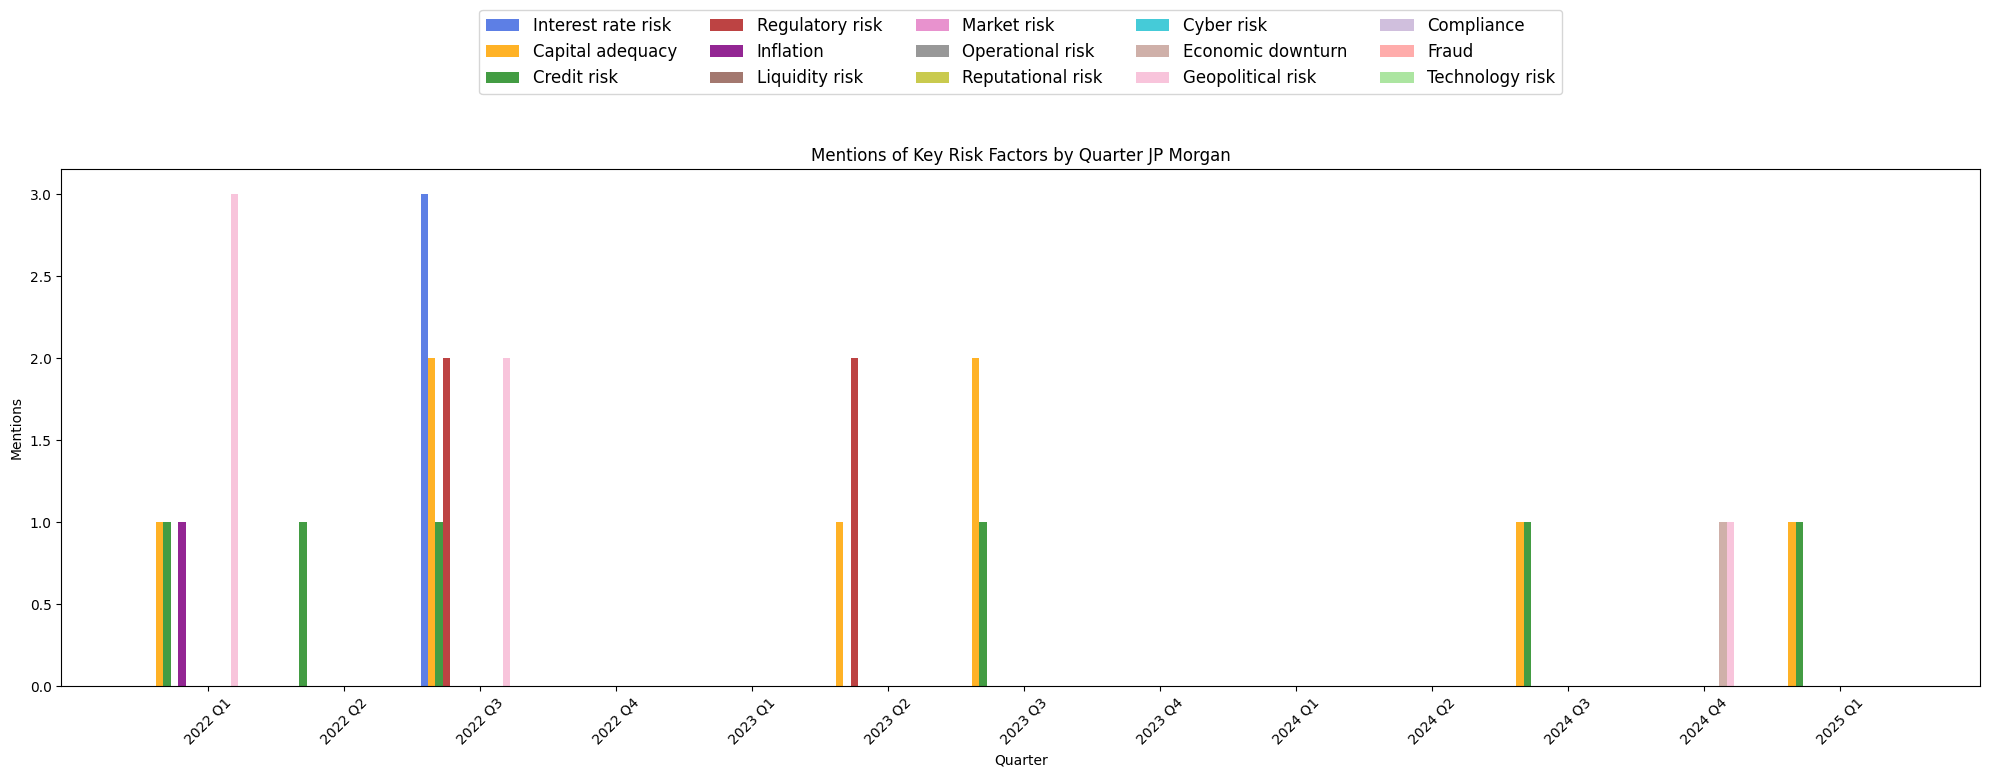

In [ ]:
# Extract and Plot Top 15 Risk Factors

import re
import matplotlib.pyplot as plt
import numpy as np

# List of risks and patterns to search for (expand as needed)
risk_patterns = {
    "Credit risk": r"credit risk|loan loss|charge[- ]off|non[- ]performing|delinquency",
    "Interest rate risk": r"interest rate|rate hike|rate increase|rate risk",
    "Liquidity risk": r"liquidity",
    "Market risk": r"market risk|market volatility|market decline",
    "Operational risk": r"operational risk|operations risk",
    "Regulatory risk": r"regulatory|regulation|compliance|regulator|Basel|CCAR|SCB",
    "Reputational risk": r"reputation|reputational",
    "Cyber risk": r"cyber|cybersecurity|cyber attack|data breach|information security",
    "Capital adequacy": r"capital adequacy|CET1|capital ratio|capital requirement",
    "Inflation": r"inflation|price increase|cost pressure",
    "Economic downturn": r"recession|downturn|slowdown|contraction",
    "Geopolitical risk": r"geopolitical|war|conflict|Russia|Ukraine|trade tension",
    "Compliance": r"compliance|non-compliance|KYC|AML",
    "Fraud": r"fraud|misconduct|scandal",
    "Technology risk": r"technology risk|IT failure|system outage|digital disruption|tech risk"
}

# Count risk mentions per summary
def extract_risks(text):
    if not isinstance(text, str):
        return {}
    counts = {}
    for risk, pattern in risk_patterns.items():
        found = len(re.findall(pattern, text, re.IGNORECASE))
        counts[risk] = found
    return counts

# Expand risk counts per row
risk_counts = combined['combined_summary'].apply(extract_risks).apply(pd.Series).fillna(0).astype(int)
risk_counts['year'] = combined['year']
risk_counts['quarter'] = combined['quarter']

# Group by quarter, sum all risk mentions
risk_trend = risk_counts.groupby(['year','quarter']).sum().reset_index()
risk_trend['quarter_str'] = risk_trend['year'].astype(str) + ' Q' + risk_trend['quarter'].astype(str)


top5_names = [
    'Interest rate risk',
    'Capital adequacy',
    'Credit risk',
    'Regulatory risk',
    'Inflation'
]
top5_colors = ['royalblue', 'orange', 'forestgreen', 'firebrick', 'purple']

other_risks = [r for r in risk_patterns.keys() if r not in top5_names]
other_colors = [
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # grey
    '#bcbd22',  # olive
    '#17becf',  # cyan
    '#c49c94',  # tan
    '#f7b6d2',  # light pink
    '#c5b0d5',  # lavender
    '#ff9896',  # salmon
    '#98df8a',  # light green
]

quarters = risk_trend['year'].astype(str) + ' Q' + risk_trend['quarter'].astype(str)
x = np.arange(len(quarters))
bar_width = 0.055

plt.figure(figsize=(20,8))

# Top 5
for i, (risk, color) in enumerate(zip(top5_names, top5_colors)):
    plt.bar(x + i*bar_width, risk_trend[risk], width=bar_width, label=risk, color=color, alpha=0.85)

# Others
for j, (risk, color) in enumerate(zip(other_risks, other_colors)):
    plt.bar(x + (j+len(top5_names))*bar_width, risk_trend[risk], width=bar_width, label=risk, color=color, alpha=0.8)

plt.xticks(x + (len(risk_patterns)/2)*bar_width, quarters, rotation=45)
plt.xlabel("Quarter")
plt.ylabel("Mentions")
plt.title("Mentions of Key Risk Factors by Quarter JP Morgan")
plt.legend(bbox_to_anchor=(0.5, 1.13), loc='lower center', ncol=5, fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
print(combined.columns)


Index(['year', 'quarter', 'mistral_summary', 'hybrid_bart',
       'combined_summary'],
      dtype='object')


In [ ]:
# Extract Metrics From Text
import re
import numpy as np

def extract_financial_metric(text, pattern):
    if not isinstance(text, str):
        return np.nan
    match = re.search(pattern, text, re.IGNORECASE)
    if match:
        value = match.group(1).replace(',', '')
        try:
            return float(value)
        except:
            return np.nan
    return np.nan

# Patterns for financial metrics
net_income_pat = r'net income (?:was|of)?\s*\$([0-9.,]+)'
eps_pat = r'EPS (?:was|of)?\s*\$([0-9.,]+)'
revenue_pat = r'revenue (?:was|of)?\s*\$([0-9.,]+)'

combined['net_income'] = combined['combined_summary'].apply(lambda x: extract_financial_metric(x, net_income_pat))
combined['eps'] = combined['combined_summary'].apply(lambda x: extract_financial_metric(x, eps_pat))
combined['revenue'] = combined['combined_summary'].apply(lambda x: extract_financial_metric(x, revenue_pat))

# Check what was extracted
print(combined[['year','quarter','net_income','eps','revenue']])


    year  quarter  net_income    eps  revenue
0   2022        1         8.3   2.63     31.6
1   2022        2         NaN    NaN     31.6
2   2022        3         9.7   3.12     33.5
3   2022        4         NaN  12.09     35.6
4   2023        1        12.6    NaN     39.3
5   2023        2        14.5   4.75     38.4
6   2023        3        13.2   4.33     40.7
7   2023        4         9.3   3.04     39.9
8   2024        1        13.4   4.44     42.5
9   2024        2        18.1   6.12     51.0
10  2024        3        12.9   4.37     43.3
11  2024        4        14.0   4.81     43.7
12  2025        1        14.6    NaN     46.0


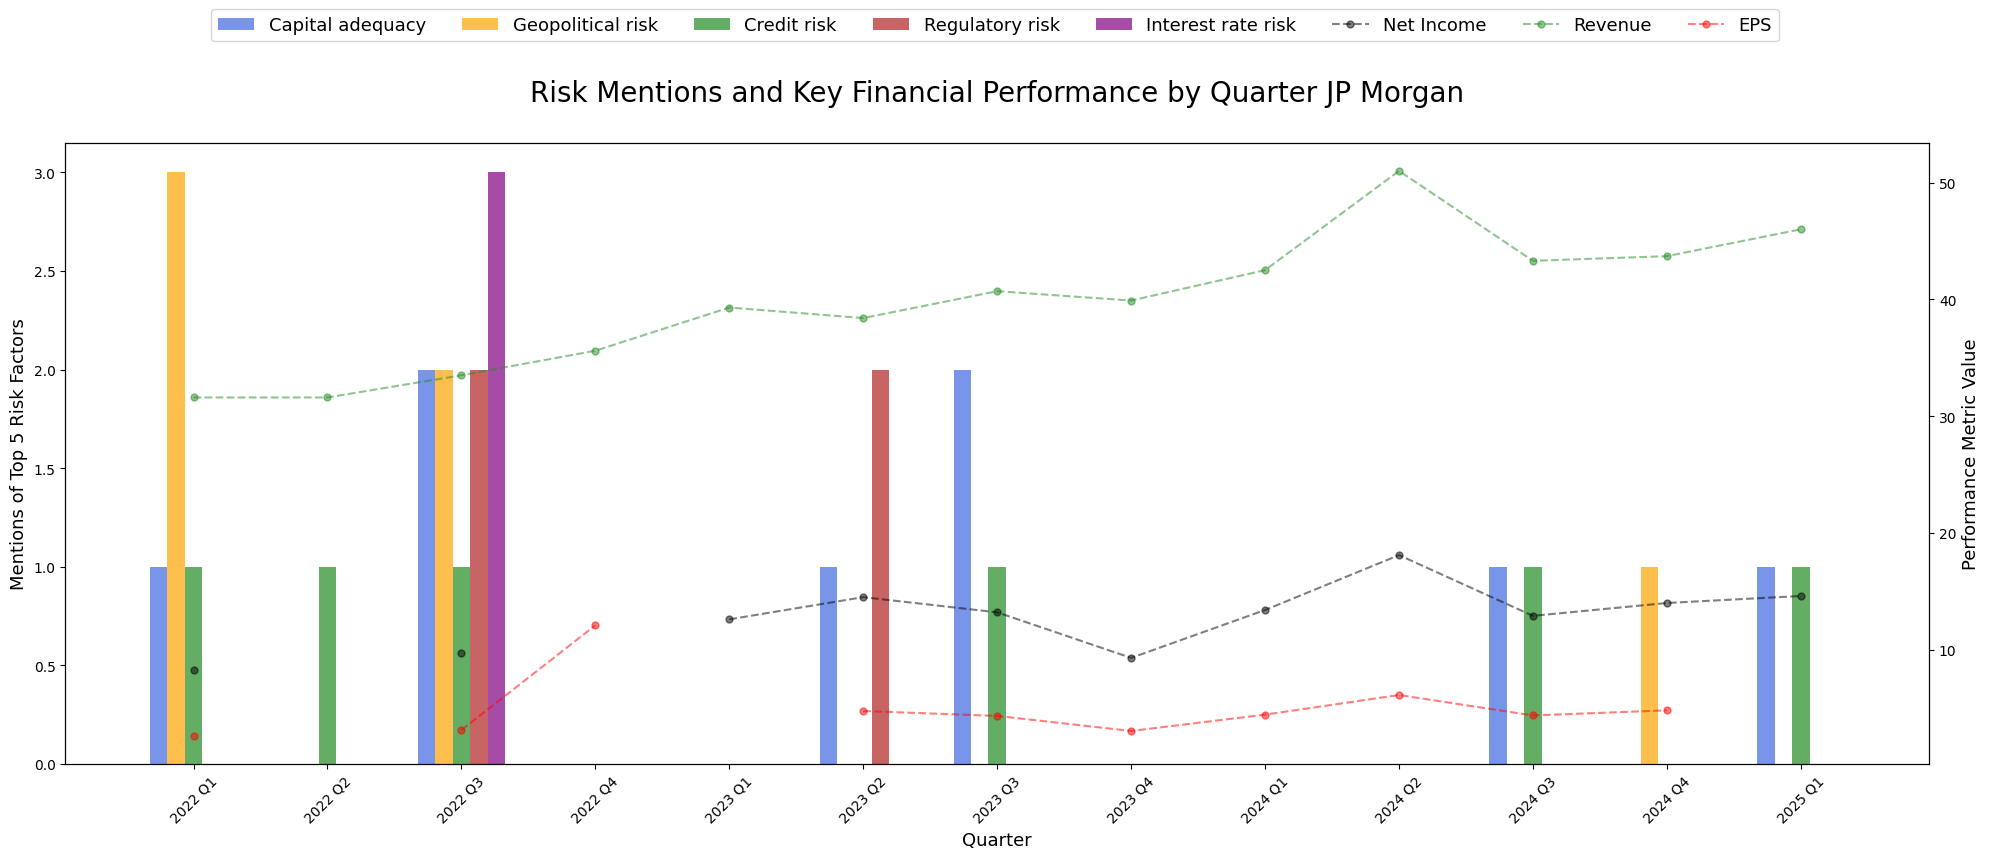

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate Top 5 Risks
risk_totals = risk_trend[[c for c in risk_trend.columns if c not in ['year', 'quarter', 'quarter_str']]].sum().sort_values(ascending=False)
top_risks = risk_totals.head(5).index.tolist()

# Prepare x-axis
quarters = risk_trend['quarter_str']
x = np.arange(len(quarters))
bar_width = 0.13
offsets = np.linspace(-bar_width*2, bar_width*2, 5)
fig, ax1 = plt.subplots(figsize=(20, 8))

# Plot bars for Top 5 Risks
colors = ['royalblue', 'orange', 'forestgreen', 'firebrick', 'purple']
for i, risk in enumerate(top_risks):
    ax1.bar(x + offsets[i], risk_trend[risk], width=bar_width, label=risk, color=colors[i], alpha=0.7)

ax1.set_xticks(x)
ax1.set_xticklabels(quarters, rotation=45)
ax1.set_ylabel("Mentions of Top 5 Risk Factors", fontsize=13)
ax1.set_xlabel("Quarter", fontsize=13)

# Overlay performance metrics (dotted, small dots, thinner lines)
ax2 = ax1.twinx()
ax2.plot(x, combined['net_income'], 'o--', color='black', label='Net Income', linewidth=1.5, markersize=5, alpha=0.5)
ax2.plot(x, combined['revenue'], 'o--', color='forestgreen', label='Revenue', linewidth=1.5, markersize=5, alpha=0.5)
ax2.plot(x, combined['eps'], 'o--', color='red', label='EPS', linewidth=1.5, markersize=5, alpha=0.5)
ax2.set_ylabel("Performance Metric Value", fontsize=13)

# Combine legends in one row above the plot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
all_lines = lines1 + lines2
all_labels = labels1 + labels2
fig.legend(
    all_lines, all_labels,
    loc='upper center', ncol=len(all_labels), fontsize=13, frameon=True, bbox_to_anchor=(0.5, 1.08)
)

plt.title("Risk Mentions and Key Financial Performance by Quarter JP Morgan", fontsize=20, pad=30)
plt.tight_layout()
plt.show()


## Section 14-4: Mistral Summarization for qna_df

In [ ]:
print(qna_df.columns)
print(qna_df.head())


Index(['question_order', 'question_answer_group_id', 'speaker', 'role',
       'company', 'content', 'year', 'quarter', 'mistral_summary'],
      dtype='object')
   question_order  question_answer_group_id           speaker  \
0               0                         1  John E. McDonald   
1               1                         1     Jeremy Barnum   
2               2                         1  John E. McDonald   
3               3                         1     Jeremy Barnum   
4               4                         1  John E. McDonald   

                      role               company  \
0                  Analyst   Autonomous Research   
1  Chief Financial Officer  JPMorgan Chase & Co.   
2                  Analyst   Autonomous Research   
3  Chief Financial Officer  JPMorgan Chase & Co.   
4                  Analyst   Autonomous Research   

                                             content  year  quarter  \
0  Thank you. Morning, Jeremy. Was wondering abou...  2022     

In [ ]:
# 1. Summarize each meeting in qna_df using Mistral-7B
def mistral_summarize(text):
    if not text or len(str(text).strip()) < 5:
        return "[Text too short for summary]"
    prompt = f"Summarize the following text for a financial analyst:\n{text}"
    try:
        generated_output = pipe(prompt, max_new_tokens=256)[0]['generated_text']
        summary = generated_output.replace(prompt, "").strip()
        return summary
    except Exception as e:
        return f"[Mistral summary failed: {e}]"

qna_df['mistral_summary'] = qna_df['content'].apply(mistral_summarize)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting

In [ ]:
print(qna_df.columns)

Index(['question_order', 'question_answer_group_id', 'speaker', 'role',
       'company', 'content', 'year', 'quarter', 'mistral_summary'],
      dtype='object')


In [ ]:
print(qna_df[['year', 'quarter', 'mistral_summary']].head(5).to_string(index=False))

 year  quarter                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
# Check for Empty or Failed Summaries

print(qna_df[qna_df['mistral_summary'].str.strip() == ''][['year', 'quarter']])

Empty DataFrame
Columns: [year, quarter]
Index: []


In [ ]:
qna_df.to_csv('qna_df_with_mistral.csv', index=False)

## Section 14.5: Compare Mistral Summarization and Hybrid Model for qna

In [ ]:
import pandas as pd

# 1. Load Mistral summaries for Q&A (already in qna_df)
# 2. Load Hybrid model summaries for Q&A
hybrid_qna = pd.read_csv('qna_meeting_summaries.csv')  # Update filename if needed

# 3. Split 'meeting' into 'year' and 'quarter'
hybrid_qna[['year', 'quarter']] = hybrid_qna['meeting'].str.split('_', expand=True)
hybrid_qna['year'] = hybrid_qna['year'].astype(int)
hybrid_qna['quarter'] = hybrid_qna['quarter'].str.replace('Q', '').astype(int)

# 4. Merge on year & quarter for easy comparison
comparison_qna = pd.merge(
    qna_df[['year', 'quarter', 'mistral_summary']],
    hybrid_qna[['year', 'quarter', 'hybrid_bart']],
    on=['year', 'quarter'],
    how='inner'
)

# 5. Display a few samples
print(comparison_qna.head(5).to_string(index=False))


 year  quarter                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
# 1. Group by year and quarter, join all Mistral summaries for that quarter
agg_mistral_qna = qna_df.groupby(['year', 'quarter'])['mistral_summary']\
    .apply(lambda x: ' '.join(x.dropna())).reset_index()

# 2. Now merge with hybrid Q&A summaries
comparison_qna = pd.merge(
    agg_mistral_qna,
    hybrid_qna[['year', 'quarter', 'hybrid_bart']],
    on=['year', 'quarter'],
    how='inner'
)

print(comparison_qna.head(10).to_string(index=False))


 year  quarter                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

## Section 14-6: Risk Factor Extraction and Performance Trend Analysis from Meeting Summaries HYBRID 2 qna_df

In [ ]:
# Combine Q&A Summaries by Quarter (Mistral first, Hybrid below)
combined_qna = comparison_qna.copy()

combined_qna['combined_summary'] = (
    "MISTRAL:\n" + combined_qna['mistral_summary'].fillna('') +
    "\n\nHYBRID:\n" + combined_qna['hybrid_bart'].fillna('')
)

# Display a few rows for review
pd.set_option('display.max_colwidth', 1000)
display(combined_qna[['year', 'quarter', 'combined_summary']].head())


,year,quarter,combined_summary
0,2022,1,"MISTRAL:\nResponse:\nGood morning. With regard to net interest income, our previous estimate provided in mid-February remains largely unchanged, despite the advancement in rate expectations. Our assumptions for net interest income exclude the expected impact of market repricing, focusing instead on the impact of the growth in the loan book and the assumption of stable funding costs. We anticipate that the loan book will grow in line with economic growth and the expansion of our lending capacity. We also assume that stable funding costs will continue, which is influenced by our large deposit base and our cost of funds hedging strategy. Additionally, we have factored in the impact of the expected reduction in the volume of securities lending income due to a decrease in customer demand. Overall, we expect net interest income to grow moderately in the coming quarters, barring any significant unexpected changes in funding costs or the economic environment. So, to answer your question, y..."
1,2022,2,"MISTRAL:\nAn investor is asking the management team of a financial institution about their capital target. The investor is concerned that the firm's current CET1 target of 12.5% to 13% may no longer be sufficient given the expected increases in the firm's G-SIB surcharge and regulatory minimum. The investor asks what the management team believes is an appropriate capital target for the long term, considering the elevated volatility of SCB and the regulatory changes. The text indicates that there will be two increases to the Global Systemically Important Bank (GSIB) surcharge in the first quarters of 2023 and 2024. The speaker had previously discussed a target range of 12.5% to 13% for the company's Common Equity Tier 1 (CET1) capital ratio, which would provide a modest buffer for the expected increase in the SCB (Sociedade de Crédito e Investimento, S.A.) surcharge. However, the actual increase in the SCB surcharge was greater than anticipated, so for now, the company is focused on..."
2,2022,3,"MISTRAL:\nResponse:\nThe speaker is asking for an analysis of how net interest income (NII) and deposit costs might be affected in the current interest rate environment, specifically in relation to beta, which measures the sensitivity of an asset or liability to interest rate changes. The speaker notes that deposit costs are starting to increase and is seeking insights into how betas might behave during this rate cycle compared to past cycles. A financial analyst should understand that during Investor Day, Jen announced that they anticipated low betas in the current cycle based on historical data. However, as interest rate hikes have occurred and deposit rates have increased, realized betas have been even lower than in the previous low beta cycle. potential explanations for this phenomenon include the speed of rate hikes and the improved liquidity position of the system. Lags in beta realization are currently significant, but will eventually be released. The timing of this release ..."
3,2022,4,"MISTRAL:\nResponse:\nGood morning, the range of deposit cost outcomes indicated on Slide 10 for NII is between 1.5% and 2%. The $74 billion NII figure is not directly aligned with the midpoint of this range. However, I'd be happy to provide some context regarding the drivers of the $74 billion NII figure and where it sits in relation to deposit cost outcomes.\n\nThe $74 billion NII figure is based on our current assumptions for net interest margin, loan growth, and deposit costs. Our net interest margin assumption is held constant at 3.35%, while our loan growth assumption is set at 3%. Deposit costs, as you noted, are the variable in this equation and span the range of 1.5% to 2%.\n\nTo determine where the $74 billion NII figure falls within this range, we calculate the interest income generated by our loan portfolio and subtract the interest expense on our deposits. Given our assumptions, the $74 billion NII fi

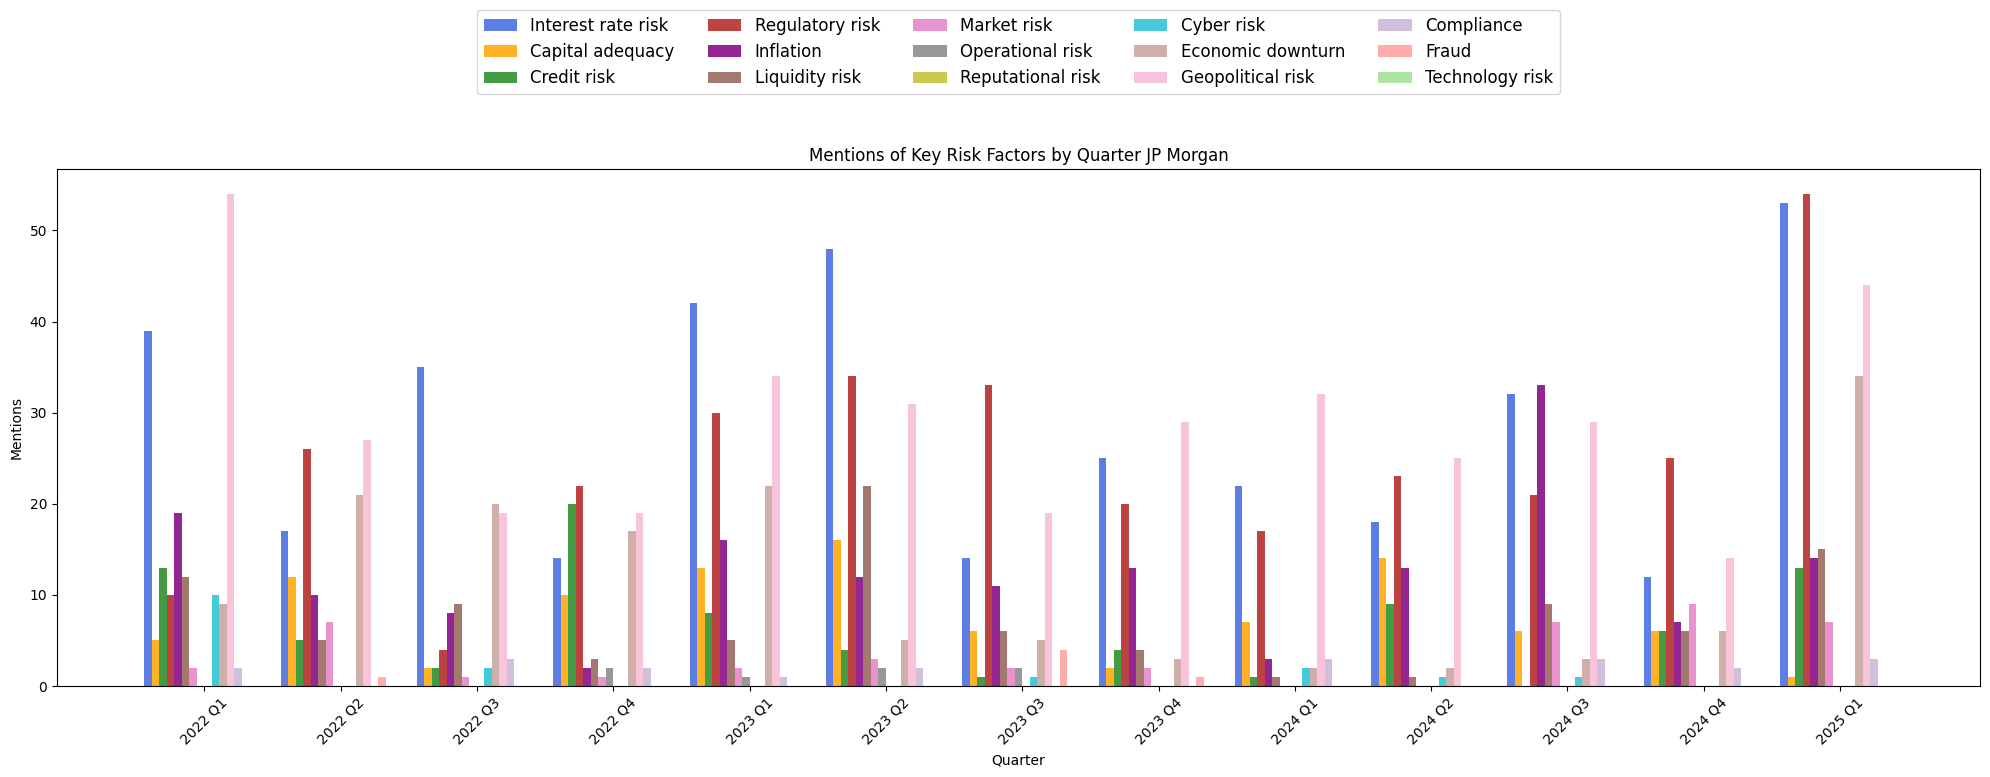

In [ ]:
# Extract and Plot Top 15 Risk Factors

import re
import matplotlib.pyplot as plt
import numpy as np

# List of risks and patterns to search for (expand as needed)
risk_patterns = {
    "Credit risk": r"credit risk|loan loss|charge[- ]off|non[- ]performing|delinquency",
    "Interest rate risk": r"interest rate|rate hike|rate increase|rate risk",
    "Liquidity risk": r"liquidity",
    "Market risk": r"market risk|market volatility|market decline",
    "Operational risk": r"operational risk|operations risk",
    "Regulatory risk": r"regulatory|regulation|compliance|regulator|Basel|CCAR|SCB",
    "Reputational risk": r"reputation|reputational",
    "Cyber risk": r"cyber|cybersecurity|cyber attack|data breach|information security",
    "Capital adequacy": r"capital adequacy|CET1|capital ratio|capital requirement",
    "Inflation": r"inflation|price increase|cost pressure",
    "Economic downturn": r"recession|downturn|slowdown|contraction",
    "Geopolitical risk": r"geopolitical|war|conflict|Russia|Ukraine|trade tension",
    "Compliance": r"compliance|non-compliance|KYC|AML",
    "Fraud": r"fraud|misconduct|scandal",
    "Technology risk": r"technology risk|IT failure|system outage|digital disruption|tech risk"
}

# Count risk mentions per summary
def extract_risks(text):
    if not isinstance(text, str):
        return {}
    counts = {}
    for risk, pattern in risk_patterns.items():
        found = len(re.findall(pattern, text, re.IGNORECASE))
        counts[risk] = found
    return counts

# Expand risk counts per row
risk_counts = combined_qna['combined_summary'].apply(extract_risks).apply(pd.Series).fillna(0).astype(int)
risk_counts['year'] = combined_qna['year']
risk_counts['quarter'] = combined_qna['quarter']

# Group by quarter, sum all risk mentions
risk_trend = risk_counts.groupby(['year','quarter']).sum().reset_index()
risk_trend['quarter_str'] = risk_trend['year'].astype(str) + ' Q' + risk_trend['quarter'].astype(str)


top5_names = [
    'Interest rate risk',
    'Capital adequacy',
    'Credit risk',
    'Regulatory risk',
    'Inflation'
]
top5_colors = ['royalblue', 'orange', 'forestgreen', 'firebrick', 'purple']

other_risks = [r for r in risk_patterns.keys() if r not in top5_names]
other_colors = [
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # grey
    '#bcbd22',  # olive
    '#17becf',  # cyan
    '#c49c94',  # tan
    '#f7b6d2',  # light pink
    '#c5b0d5',  # lavender
    '#ff9896',  # salmon
    '#98df8a',  # light green
]

quarters = risk_trend['year'].astype(str) + ' Q' + risk_trend['quarter'].astype(str)
x = np.arange(len(quarters))
bar_width = 0.055

plt.figure(figsize=(20,8))

# Top 5
for i, (risk, color) in enumerate(zip(top5_names, top5_colors)):
    plt.bar(x + i*bar_width, risk_trend[risk], width=bar_width, label=risk, color=color, alpha=0.85)

# Others
for j, (risk, color) in enumerate(zip(other_risks, other_colors)):
    plt.bar(x + (j+len(top5_names))*bar_width, risk_trend[risk], width=bar_width, label=risk, color=color, alpha=0.8)

plt.xticks(x + (len(risk_patterns)/2)*bar_width, quarters, rotation=45)
plt.xlabel("Quarter")
plt.ylabel("Mentions")
plt.title("Mentions of Key Risk Factors by Quarter JP Morgan")
plt.legend(bbox_to_anchor=(0.5, 1.13), loc='lower center', ncol=5, fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Extract Metrics From Text
import re
import numpy as np

def extract_financial_metric(text, pattern):
    if not isinstance(text, str):
        return np.nan
    match = re.search(pattern, text, re.IGNORECASE)
    if match:
        value = match.group(1).replace(',', '')
        try:
            return float(value)
        except:
            return np.nan
    return np.nan

# Patterns for financial metrics
net_income_pat = r'net income (?:was|of)?\s*\$([0-9.,]+)'
eps_pat = r'EPS (?:was|of)?\s*\$([0-9.,]+)'
revenue_pat = r'revenue (?:was|of)?\s*\$([0-9.,]+)'

combined_qna['net_income'] = combined_qna['combined_summary'].apply(lambda x: extract_financial_metric(x, net_income_pat))
combined_qna['eps'] = combined_qna['combined_summary'].apply(lambda x: extract_financial_metric(x, eps_pat))
combined_qna['revenue'] = combined_qna['combined_summary'].apply(lambda x: extract_financial_metric(x, revenue_pat))

# Check what was extracted
print(combined_qna[['year','quarter','net_income','eps','revenue']])

    year  quarter  net_income   eps  revenue
0   2022        1        1.70   NaN      NaN
1   2022        2        1.30   NaN    75.80
2   2022        3        1.36   NaN     5.47
3   2022        4        8.80  1.14    50.00
4   2023        1       12.00   NaN    50.00
5   2023        2       20.00   NaN      NaN
6   2023        3      650.00   NaN     1.50
7   2023        4         NaN   NaN      NaN
8   2024        1      493.00  1.22     1.20
9   2024        2         NaN   NaN    21.50
10  2024        3         NaN   NaN   884.00
11  2024        4       65.00   NaN    15.00
12  2025        1      150.00   NaN     1.20


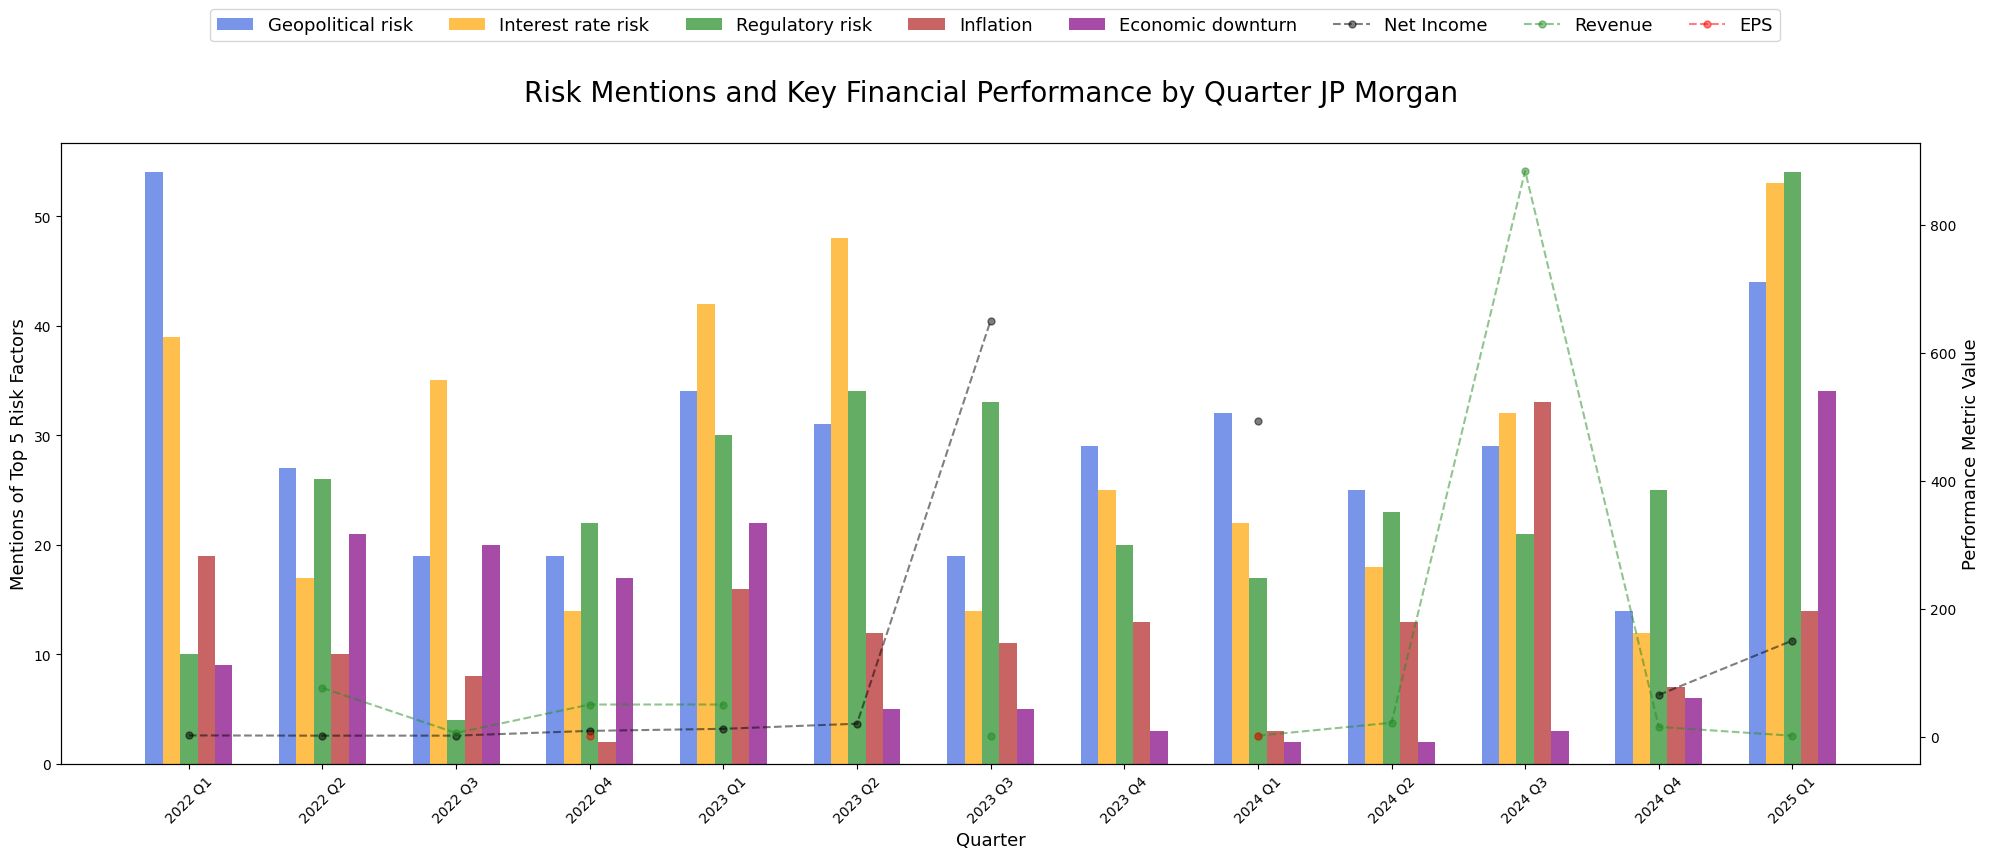

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate Top 5 Risks
risk_totals = risk_trend[[c for c in risk_trend.columns if c not in ['year', 'quarter', 'quarter_str']]].sum().sort_values(ascending=False)
top_risks = risk_totals.head(5).index.tolist()

# Prepare x-axis
quarters = risk_trend['quarter_str']
x = np.arange(len(quarters))
bar_width = 0.13
offsets = np.linspace(-bar_width*2, bar_width*2, 5)
fig, ax1 = plt.subplots(figsize=(20, 8))

# Plot bars for Top 5 Risks
colors = ['royalblue', 'orange', 'forestgreen', 'firebrick', 'purple']
for i, risk in enumerate(top_risks):
    ax1.bar(x + offsets[i], risk_trend[risk], width=bar_width, label=risk, color=colors[i], alpha=0.7)

ax1.set_xticks(x)
ax1.set_xticklabels(quarters, rotation=45)
ax1.set_ylabel("Mentions of Top 5 Risk Factors", fontsize=13)
ax1.set_xlabel("Quarter", fontsize=13)

# Overlay performance metrics (dotted, small dots, thinner lines)
ax2 = ax1.twinx()
ax2.plot(x, combined_qna['net_income'], 'o--', color='black', label='Net Income', linewidth=1.5, markersize=5, alpha=0.5)
ax2.plot(x, combined_qna['revenue'], 'o--', color='forestgreen', label='Revenue', linewidth=1.5, markersize=5, alpha=0.5)
ax2.plot(x, combined_qna['eps'], 'o--', color='red', label='EPS', linewidth=1.5, markersize=5, alpha=0.5)
ax2.set_ylabel("Performance Metric Value", fontsize=13)

# Combine legends in one row above the plot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
all_lines = lines1 + lines2
all_labels = labels1 + labels2
fig.legend(
    all_lines, all_labels,
    loc='upper center', ncol=len(all_labels), fontsize=13, frameon=True, bbox_to_anchor=(0.5, 1.08)
)

plt.title("Risk Mentions and Key Financial Performance by Quarter JP Morgan", fontsize=20, pad=30)
plt.tight_layout()
plt.show()